<a href="https://colab.research.google.com/github/jasepark2/TTR-Repository/blob/master/Another_copy_of_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Step by Step Backpropagation for MNIST Classification**

We will implement a simple fully connected network with different activation layers for the MNIST classification problem.



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.36MB/s]


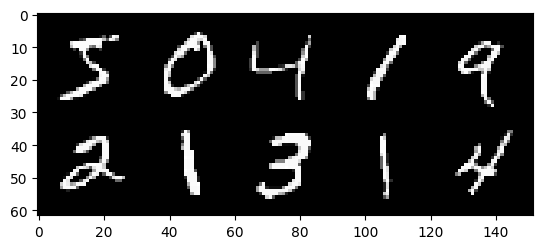

In [ ]:
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


batch_size = 128
learning_rate = 1e-2
reg = 1e-3
epochs = 200

download_root = './MNIST_DATASET'
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data = [train_dataset[i][0] for i in range(10)]
sample = make_grid(data, nrow=5)
plt.imshow(sample.permute(1, 2, 0), cmap='gray')
plt.show()

In [ ]:
def one_hot_encode(y):
  one_hot_label = np.zeros((y.shape[0], 10))
  one_hot_label[range(y.shape[0]), y] = 1

  return one_hot_label

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def cross_entropy(y_hat, y):
  L = -np.sum(y * np.log(y_hat)) / y_hat.shape[0]
  dL = (y_hat - y) / y_hat.shape[0]

  return L, dL

class Sigmoid(object):
  def __init__(self):
    self.input, self.output = None, None

  def forward(self, x, W, b):
    self.input = x.copy()
    y = np.dot(x, W) + b
    self.output = 1 / (1 + np.exp(-y))
    return self.output

  def backward(self, grad):
    return self.output * (1 - self.output) * grad

class Tanh():
  def __init__(self):
    self.input, self.output = None, None

  def forward(self, x, W, b):
    self.input = x.copy()
    y = np.dot(x, W) + b
    self.output = (np.exp(y) - np.exp(-y))/(np.exp(y) + np.exp(-y))
    return self.output

  def backward(self, grad):
    return (1 + self.output) * (1 - self.output) * grad

class ReLU():
  def __init__(self):
    self.input, self.output = None, None

  def forward(self, x, W, b):
    self.input = x.copy()
    y = np.dot(x, W) + b
    self.output = np.maximum(0, y)
    return self.output

  def backward(self, grad):
    return (self.output > 0).astype(int) * grad

class Identity():
  def __init__(self):
    self.input, self.output = None, None

  def forward(self, x, W, b):
    self.input = x.copy()
    y = np.dot(x, W) + b
    self.output = y
    return self.output

  def backward(self, grad):
    return grad


class NeuralNetwork(object):
  def __init__(self, layers = [28 * 28, 128, 64, 10], nodes=[Tanh(), ReLU(), Identity()]):
    self.Ws = [np.random.rand(layers[i], layers[i+1]) - 0.5 for i in range(len(layers) - 1)]
    self.bs = [np.random.rand(1, layers[i+1]) - 0.5 for i in range(len(layers) - 1)]
    self.dWs = None
    self.dbs = None

    self.nodes = nodes

  def calc_loss(self, pred, gt):
    loss, grad = cross_entropy(softmax(pred), gt)

    return loss, grad

  def calc_correct(self, pred, gt):
    pred = np.argmax(pred, axis=1)

    return np.sum(pred == gt)

  def forward(self, x):
    x = x.reshape((x.shape[0], -1))
    for W, b, node in zip(self.Ws, self.bs, self.nodes):
      x = node.forward(x, W, b)

    return x

  def backward(self, grad, lr):
    self.dWs = []
    self.dbs = []

    for W, b, node in zip(reversed(self.Ws), reversed(self.bs), reversed(self.nodes)):
      grad = node.backward(grad)
      dW = np.dot(node.input.T, grad) + reg * W ** 2
      db = np.sum(grad, axis=0, keepdims=True)

      W -= lr * dW
      b -= lr * db

      grad = np.dot(grad, W.T)

In [ ]:
model = NeuralNetwork(layers = [28 * 28, 128, 64, 10], nodes=[Tanh(), ReLU(), Identity()])
print('Train Size:', len(train_dataset))
print('Test Size:', len(test_dataset))
for epoch in range(epochs):
  train_correct = 0
  test_correct = 0
  loss_all = 0.0

  for data, label in train_loader:
    data = data.numpy()
    label = label.numpy()

    pred = model.forward(data)
    loss, grad = model.calc_loss(pred, one_hot_encode(label))
    model.backward(grad, learning_rate)
    train_correct += model.calc_correct(pred, label)
    loss_all += loss

  for data, label in test_loader:
    data = data.numpy()
    label = label.numpy()
    pred = model.forward(data)
    test_correct += model.calc_correct(pred, label)

  print('Epoch: {:3d} | LR: {:.03f} | Loss: {:.06f} | Train Acc: {:.02f}% | Test Acc: {:.02f}%'.format(
          epoch + 1, learning_rate, loss_all / len(train_loader), train_correct * 100 / len(train_dataset), test_correct * 100 / len(test_dataset)))


Train Size: 60000
Test Size: 10000
Epoch:   1 | LR: 0.010 | Loss: 1.532396 | Train Acc: 55.05% | Test Acc: 72.88%
Epoch:   2 | LR: 0.010 | Loss: 0.765962 | Train Acc: 75.65% | Test Acc: 79.63%
Epoch:   3 | LR: 0.010 | Loss: 0.626223 | Train Acc: 80.15% | Test Acc: 82.47%
Epoch:   4 | LR: 0.010 | Loss: 0.552522 | Train Acc: 82.59% | Test Acc: 84.10%
Epoch:   5 | LR: 0.010 | Loss: 0.503669 | Train Acc: 84.11% | Test Acc: 85.59%
Epoch:   6 | LR: 0.010 | Loss: 0.467753 | Train Acc: 85.28% | Test Acc: 86.17%
Epoch:   7 | LR: 0.010 | Loss: 0.439896 | Train Acc: 86.23% | Test Acc: 86.91%
Epoch:   8 | LR: 0.010 | Loss: 0.417188 | Train Acc: 86.92% | Test Acc: 87.40%
Epoch:   9 | LR: 0.010 | Loss: 0.397977 | Train Acc: 87.59% | Test Acc: 88.24%
Epoch:  10 | LR: 0.010 | Loss: 0.381930 | Train Acc: 88.03% | Test Acc: 88.50%
Epoch:  11 | LR: 0.010 | Loss: 0.367687 | Train Acc: 88.50% | Test Acc: 88.70%
Epoch:  12 | LR: 0.010 | Loss: 0.355152 | Train Acc: 88.97% | Test Acc: 89.12%
Epoch:  13 | LR: 

In [ ]:
# Select some examples of 3s and 8s from the test set
sample_indices = []
for i in range(len(test_dataset)):
    if test_dataset[i][1] in [3, 8] and len(sample_indices) < 10: # Get up to 10 samples of 3s and 8s
        sample_indices.append(i)
    if len(sample_indices) == 10:
        break

sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

# Prepare the data for the model
sample_data = np.stack([img.numpy() for img in sample_images])

# Get model predictions
model_predictions = model.forward(sample_data)
predicted_labels = np.argmax(model_predictions, axis=1)

# Display the images and predictions
fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 3))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i].permute(1, 2, 0), cmap='gray')
    ax.set_title(f'True: {sample_labels[i]}\nPred: {predicted_labels[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

In [ ]:
model = NeuralNetwork(layers = [28 * 28, 128, 64, 10], nodes=[Tanh(), ReLU(), Identity()])

NameError: name 'NeuralNetwork' is not defined

In [ ]:
# Select some examples of 3s and 8s from the test set
sample_indices = []
for i in range(len(test_dataset)):
    if test_dataset[i][1] in [3, 8] and len(sample_indices) < 10: # Get up to 10 samples of 3s and 8s
        sample_indices.append(i)
    if len(sample_indices) == 10:
        break

sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

# Prepare the data for the model
sample_data = np.stack([img.numpy() for img in sample_images])

# Get model predictions
model_predictions = model.forward(sample_data)
predicted_labels = np.argmax(model_predictions, axis=1)

# Display the images and predictions
fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 3))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i].permute(1, 2, 0), cmap='gray')
    ax.set_title(f'True: {sample_labels[i]}\nPred: {predicted_labels[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

In [ ]:
def one_hot_encode(y):
  one_hot_label = np.zeros((y.shape[0], 10))
  one_hot_label[range(y.shape[0]), y] = 1

  return one_hot_label

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def cross_entropy(y_hat, y):
  L = -np.sum(y * np.log(y_hat)) / y_hat.shape[0]
  dL = (y_hat - y) / y_hat.shape[0]

  return L, dL

class Sigmoid(object):
  def __init__(self):
    self.input, self.output = None, None

  def forward(self, x, W, b):
    self.input = x.copy()
    y = np.dot(x, W) + b
    self.output = 1 / (1 + np.exp(-y))
    return self.output

  def backward(self, grad):
    return self.output * (1 - self.output) * grad

class Tanh():
  def __init__(self):
    self.input, self.output = None, None

  def forward(self, x, W, b):
    self.input = x.copy()
    y = np.dot(x, W) + b
    self.output = (np.exp(y) - np.exp(-y))/(np.exp(y) + np.exp(-y))
    return self.output

  def backward(self, grad):
    return (1 + self.output) * (1 - self.output) * grad

class ReLU():
  def __init__(self):
    self.input, self.output = None, None

  def forward(self, x, W, b):
    self.input = x.copy()
    y = np.dot(x, W) + b
    self.output = np.maximum(0, y)
    return self.output

  def backward(self, grad):
    return (self.output > 0).astype(int) * grad

class Identity():
  def __init__(self):
    self.input, self.output = None, None

  def forward(self, x, W, b):
    self.input = x.copy()
    y = np.dot(x, W) + b
    self.output = y
    return self.output

  def backward(self, grad):
    return grad


class NeuralNetwork(object):
  def __init__(self, layers = [28 * 28, 128, 64, 10], nodes=[Tanh(), ReLU(), Identity()]):
    self.Ws = [np.random.rand(layers[i], layers[i+1]) - 0.5 for i in range(len(layers) - 1)]
    self.bs = [np.random.rand(1, layers[i+1]) - 0.5 for i in range(len(layers) - 1)]
    self.dWs = None
    self.dbs = None

    self.nodes = nodes

  def calc_loss(self, pred, gt):
    loss, grad = cross_entropy(softmax(pred), gt)

    return loss, grad

  def calc_correct(self, pred, gt):
    pred = np.argmax(pred, axis=1)

    return np.sum(pred == gt)

  def forward(self, x):
    x = x.reshape((x.shape[0], -1))
    for W, b, node in zip(self.Ws, self.bs, self.nodes):
      x = node.forward(x, W, b)

    return x

  def backward(self, grad, lr):
    self.dWs = []
    self.dbs = []

    for W, b, node in zip(reversed(self.Ws), reversed(self.bs), reversed(self.nodes)):
      grad = node.backward(grad)
      dW = np.dot(node.input.T, grad) + reg * W ** 2
      db = np.sum(grad, axis=0, keepdims=True)

      W -= lr * dW
      b -= lr * db

      grad = np.dot(grad, W.T)

In [ ]:
model = NeuralNetwork(layers = [28 * 28, 128, 64, 10], nodes=[Tanh(), ReLU(), Identity()])

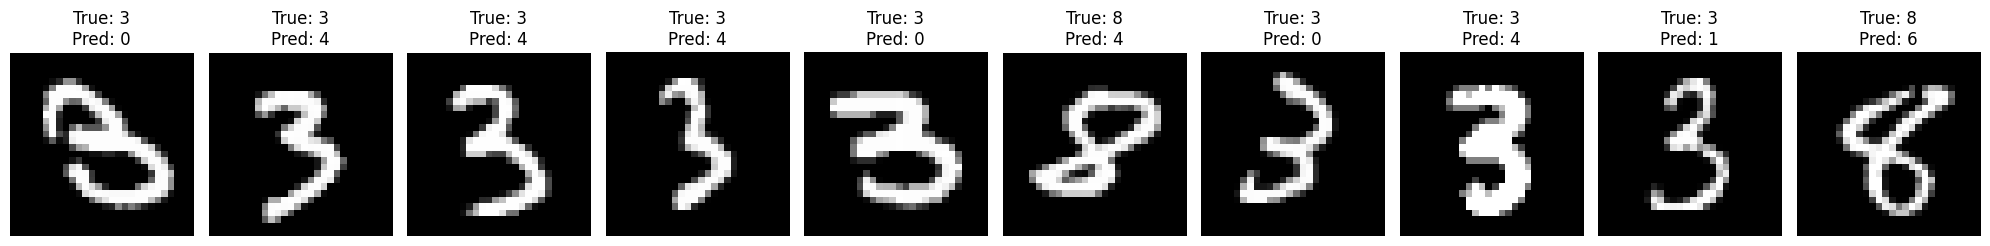

In [ ]:
# Select some examples of 3s and 8s from the test set
sample_indices = []
for i in range(len(test_dataset)):
    if test_dataset[i][1] in [3, 8] and len(sample_indices) < 10: # Get up to 10 samples of 3s and 8s
        sample_indices.append(i)
    if len(sample_indices) == 10:
        break

sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

# Prepare the data for the model
sample_data = np.stack([img.numpy() for img in sample_images])

# Get model predictions
model_predictions = model.forward(sample_data)
predicted_labels = np.argmax(model_predictions, axis=1)

# Display the images and predictions
fig, axes = plt.subplots(1, len(sample_images), figsize=(20, 3))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i].permute(1, 2, 0), cmap='gray')
    ax.set_title(f'True: {sample_labels[i]}\nPred: {predicted_labels[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Task
초보자를 위한 CNN 작동 방식, 필터링, 순전파, 역전파, One-Hot Encoding, ReLU, Softmax 등을 단계별로 설명하는 블로그 글을 작성해 주세요. MNIST 예제를 활용하여 각 개념을 설명하고 시각적인 예시를 포함해 주세요.

## 블로그 글 개요 작성

### Subtask:
블로그 글의 전체적인 구조와 각 섹션에서 다룰 내용을 간략하게 정리합니다.


**Reasoning**:
I need to outline the structure of the blog post based on the instructions. This involves creating a plan that covers the introduction, CNN components, training process, MNIST example, and conclusion. I will use a markdown block to present this structure clearly.



In [ ]:
```markdown
## 블로그 글 구조 개요

이 블로그 글은 초보자를 대상으로 CNN의 작동 방식을 MNIST 분류 예제를 통해 단계별로 설명합니다.

### 1. 도입: CNN과 MNIST 데이터셋 소개
- CNN이란 무엇이며 왜 이미지 분류에 효과적인가?
- MNIST 데이터셋 소개 (손글씨 숫자 이미지, 데이터의 특징)
- 이 글에서 다룰 주요 내용 간략히 언급 (CNN 구성 요소, 학습 과정, MNIST 예제 적용)

### 2. CNN의 주요 구성 요소
#### 2.1. 컨볼루션 레이어와 필터링
- 컨볼루션 연산의 개념 설명 (이미지에 필터를 적용)
- 필터(커널)의 역할 및 특징 추출 과정 설명
- 시각적인 예시 포함 (간단한 이미지와 필터 적용 결과)

#### 2.2. 활성화 함수 (ReLU)
- 활성화 함수의 필요성 설명 (비선형성 도입)
- ReLU 함수의 개념 및 작동 방식 설명
- ReLU가 신경망 성능에 미치는 영향 간략히 언급

#### 2.3. 풀링 레이어
- 풀링의 목적 설명 (차원 축소, 계산량 감소, 특징 불변성)
- 맥스 풀링(Max Pooling)과 평균 풀링(Average Pooling) 설명
- 풀링 과정의 시각적인 예시 포함

#### 2.4. 완전 연결 레이어
- 완전 연결 레이어의 역할 설명 (추출된 특징을 바탕으로 최종 분류)
- CNN에서 완전 연결 레이어가 위치하는 곳 설명

### 3. 신경망 학습 과정
#### 3.1. 순전파 (Forward Propagation)
- 입력 데이터가 신경망을 통과하여 최종 출력(예측)을 생성하는 과정 설명
- 각 레이어에서 수행되는 연산 간략히 언급

#### 3.화2. 손실 함수와 One-Hot Encoding
- 손실 함수의 역할 설명 (예측과 실제 값의 차이 측정)
- 크로스 엔트로피(Cross-Entropy) 손실 함수 설명
- 분류 문제에서 One-Hot Encoding의 필요성 및 작동 방식 설명 (실제 레이블 표현)

#### 3.3. 소프트맥스 함수
- 소프트맥스 함수의 역할 설명 (출력을 확률 분포로 변환)
- 각 클래스에 속할 확률 계산 과정 설명

#### 3.4. 역전파 (Backpropagation)
- 손실 함수 값을 최소화하기 위해 가중치와 편향을 업데이트하는 과정 설명
- 기울기(gradient) 계산 및 경사 하강법(Gradient Descent) 설명
- 각 레이어에서 기울기가 어떻게 전달되는지 간략히 언급

### 4. MNIST 예제를 통한 개념 적용
- MNIST 데이터를 CNN 모델에 입력하여 분류하는 전체 과정 설명
- 코드 예시 (또는 코드 흐름 설명)를 통해 각 구성 요소와 학습 과정이 어떻게 구현되는지 보여줌
- 훈련 및 테스트 결과 (손실, 정확도) 제시 및 해석

### 5. 결론 및 추가 학습 방향
- 글의 주요 내용 요약 (CNN의 핵심 개념 및 학습 과정)
- MNIST 예제를 통해 얻은 결과 다시 언급
- CNN 심화 학습을 위한 추가 주제 제시 (다양한 CNN 아키텍처, 데이터 증강, 규제 기법 등)

SyntaxError: invalid syntax (ipython-input-1438772409.py, line 1)

**Reasoning**:
The previous command failed because markdown content was placed inside a `code_block`. I need to regenerate the outline using a markdown cell instead.



In [ ]:
```markdown
## 블로그 글 구조 개요

이 블로그 글은 초보자를 대상으로 CNN의 작동 방식을 MNIST 분류 예제를 통해 단계별로 설명합니다.

### 1. 도입: CNN과 MNIST 데이터셋 소개
- CNN이란 무엇이며 왜 이미지 분류에 효과적인가?
- MNIST 데이터셋 소개 (손글씨 숫자 이미지, 데이터의 특징)
- 이 글에서 다룰 주요 내용 간략히 언급 (CNN 구성 요소, 학습 과정, MNIST 예제 적용)

### 2. CNN의 주요 구성 요소
#### 2.1. 컨볼루션 레이어와 필터링
- 컨볼루션 연산의 개념 설명 (이미지에 필터를 적용)
- 필터(커널)의 역할 및 특징 추출 과정 설명
- 시각적인 예시 포함 (간단한 이미지와 필터 적용 결과)

#### 2.2. 활성화 함수 (ReLU)
- 활성화 함수의 필요성 설명 (비선형성 도입)
- ReLU 함수의 개념 및 작동 방식 설명
- ReLU가 신경망 성능에 미치는 영향 간략히 언급

#### 2.3. 풀링 레이어
- 풀링의 목적 설명 (차원 축소, 계산량 감소, 특징 불변성)
- 맥스 풀링(Max Pooling)과 평균 풀링(Average Pooling) 설명
- 풀링 과정의 시각적인 예시 포함

#### 2.4. 완전 연결 레이어
- 완전 연결 레이어의 역할 설명 (추출된 특징을 바탕으로 최종 분류)
- CNN에서 완전 연결 레이어가 위치하는 곳 설명

### 3. 신경망 학습 과정
#### 3.1. 순전파 (Forward Propagation)
- 입력 데이터가 신경망을 통과하여 최종 출력(예측)을 생성하는 과정 설명
- 각 레이어에서 수행되는 연산 간략히 언급

#### 3.화2. 손실 함수와 One-Hot Encoding
- 손실 함수의 역할 설명 (예측과 실제 값의 차이 측정)
- 크로스 엔트로피(Cross-Entropy) 손실 함수 설명
- 분류 문제에서 One-Hot Encoding의 필요성 및 작동 방식 설명 (실제 레이블 표현)

#### 3.3. 소프트맥스 함수
- 소프트맥스 함수의 역할 설명 (출력을 확률 분포로 변환)
- 각 클래스에 속할 확률 계산 과정 설명

#### 3.4. 역전파 (Backpropagation)
- 손실 함수 값을 최소화하기 위해 가중치와 편향을 업데이트하는 과정 설명
- 기울기(gradient) 계산 및 경사 하강법(Gradient Descent) 설명
- 각 레이어에서 기울기가 어떻게 전달되는지 간략히 언급

### 4. MNIST 예제를 통한 개념 적용
- MNIST 데이터를 CNN 모델에 입력하여 분류하는 전체 과정 설명
- 코드 예시 (또는 코드 흐름 설명)를 통해 각 구성 요소와 학습 과정이 어떻게 구현되는지 보여줌
- 훈련 및 테스트 결과 (손실, 정확도) 제시 및 해석

### 5. 결론 및 추가 학습 방향
- 글의 주요 내용 요약 (CNN의 핵심 개념 및 학습 과정)
- MNIST 예제를 통해 얻은 결과 다시 언급
- CNN 심화 학습을 위한 추가 주제 제시 (다양한 CNN 아키텍처, 데이터 증강, 규제 기법 등)

SyntaxError: invalid syntax (ipython-input-1438772409.py, line 1)

## Cnn 소개

### Subtask:
CNN이 무엇인지, 왜 이미지 처리에 효과적인지 기본적인 개념을 설명합니다. (예: 픽셀, 채널 등)


**Reasoning**:
Define what a CNN is and why it's effective for image processing compared to traditional neural networks, explaining basic image components like pixels and channels, and mentioning how CNNs learn spatial hierarchies using the MNIST dataset as an example for the introduction of the blog post.



In [ ]:
# This code block generates the markdown content for the introduction section of the blog post.
# It explains what a CNN is, why it's suitable for image processing,
# basic image components (pixels, channels), spatial hierarchy learning,
# and introduces the MNIST dataset.

introduction_markdown = """
## 1. 도입: CNN과 MNIST 데이터셋 소개

안녕하세요! 오늘은 이미지 처리 분야에서 혁신을 가져온 **합성곱 신경망(Convolutional Neural Network, CNN)**에 대해 알아보겠습니다. 여러분이 스마트폰으로 사진을 찍으면 자동으로 얼굴을 인식하거나, 자율 주행차가 도로의 표지판을 읽는 등, 이미지와 관련된 다양한 인공지능 기술 뒤에는 바로 이 CNN이 핵심적인 역할을 하고 있습니다.

그렇다면 CNN은 무엇이며, 왜 이미지 처리 작업에 특히 강력할까요? 기존의 신경망(fully connected networks)은 이미지의 모든 픽셀을 개별적인 입력으로 받아 처리합니다. 하지만 이미지는 단순히 픽셀의 나열이 아니라, 픽셀들이 모여 특정 패턴(예: 에지, 코너)을 만들고, 이러한 패턴들이 다시 모여 객체의 부분, 그리고 최종적으로 객체 전체를 형성하는 **공간적인 구조(spatial structure)**를 가지고 있습니다. 기존 신경망은 이러한 공간적 관계를 효과적으로 포착하기 어렵다는 한계가 있습니다.

반면에 CNN은 **컨볼루션(Convolution)**이라는 특별한 연산을 사용하여 이미지의 공간적 특징을 추출하고 분석하는 데 특화되어 있습니다. 마치 사람이 눈으로 이미지를 볼 때 전체를 한 번에 인식하기보다 특정 부분(예: 눈, 코)을 먼저 인지하고 이를 조합하여 전체 얼굴을 인식하는 과정과 유사합니다.

이미지 데이터의 가장 기본적인 구성 요소는 **픽셀(Pixel)**입니다. 각 픽셀은 이미지의 한 점의 색상 정보를 담고 있습니다. 이미지는 이러한 픽셀들이 모여 격자 형태로 이루어집니다. **채널(Channel)**은 색상 정보를 나타내는 차원입니다. 예를 들어, 흑백 이미지의 경우 밝기 정보만을 가지는 **단일 채널**로 구성됩니다. 컬러 이미지의 경우 일반적으로 빨간색(Red), 녹색(Green), 파란색(Blue) 세 가지 색상 정보를 가지는 **3개의 채널(RGB)**로 구성됩니다. CNN은 이러한 채널별 정보를 함께 처리하여 이미지의 특징을 파악합니다.

CNN은 여러 겹의 레이어를 거치면서 이미지의 **공간적 계층 구조(spatial hierarchy)**를 단계적으로 학습합니다. 초기 레이어에서는 에지, 코너, 간단한 텍스처와 같은 기본적인 **저수준 특징(low-level features)**을 감지하고, 후반부 레이어로 갈수록 이러한 저수준 특징들을 조합하여 객체의 부분이나 객체 전체와 같은 더 복잡하고 추상적인 **고수준 특징(high-level features)**을 인식하게 됩니다. 이러한 계층적인 특징 학습 능력 덕분에 CNN은 이미지 분류, 객체 탐지, 이미지 생성 등 다양한 비전(vision) 태스크에서 뛰어난 성능을 보입니다.

이 글에서는 손글씨 숫자 이미지로 구성된 유명한 데이터셋인 **MNIST**를 예제로 사용하여 CNN의 작동 방식을 단계별로 자세히 설명할 예정입니다. MNIST 데이터셋은 각 이미지가 28x28 픽셀의 회색조 이미지로, 총 10개의 클래스(0부터 9까지의 숫자)로 분류됩니다. 비교적 단순하지만 CNN의 이미지 분류 능력을 시각적으로 이해하는 데 매우 좋은 예제입니다.

다음 섹션에서는 CNN의 핵심 구성 요소들에 대해 더 자세히 알아보겠습니다.
"""

print(introduction_markdown)


## 1. 도입: CNN과 MNIST 데이터셋 소개

안녕하세요! 오늘은 이미지 처리 분야에서 혁신을 가져온 **합성곱 신경망(Convolutional Neural Network, CNN)**에 대해 알아보겠습니다. 여러분이 스마트폰으로 사진을 찍으면 자동으로 얼굴을 인식하거나, 자율 주행차가 도로의 표지판을 읽는 등, 이미지와 관련된 다양한 인공지능 기술 뒤에는 바로 이 CNN이 핵심적인 역할을 하고 있습니다.

그렇다면 CNN은 무엇이며, 왜 이미지 처리 작업에 특히 강력할까요? 기존의 신경망(fully connected networks)은 이미지의 모든 픽셀을 개별적인 입력으로 받아 처리합니다. 하지만 이미지는 단순히 픽셀의 나열이 아니라, 픽셀들이 모여 특정 패턴(예: 에지, 코너)을 만들고, 이러한 패턴들이 다시 모여 객체의 부분, 그리고 최종적으로 객체 전체를 형성하는 **공간적인 구조(spatial structure)**를 가지고 있습니다. 기존 신경망은 이러한 공간적 관계를 효과적으로 포착하기 어렵다는 한계가 있습니다.

반면에 CNN은 **컨볼루션(Convolution)**이라는 특별한 연산을 사용하여 이미지의 공간적 특징을 추출하고 분석하는 데 특화되어 있습니다. 마치 사람이 눈으로 이미지를 볼 때 전체를 한 번에 인식하기보다 특정 부분(예: 눈, 코)을 먼저 인지하고 이를 조합하여 전체 얼굴을 인식하는 과정과 유사합니다.

이미지 데이터의 가장 기본적인 구성 요소는 **픽셀(Pixel)**입니다. 각 픽셀은 이미지의 한 점의 색상 정보를 담고 있습니다. 이미지는 이러한 픽셀들이 모여 격자 형태로 이루어집니다. **채널(Channel)**은 색상 정보를 나타내는 차원입니다. 예를 들어, 흑백 이미지의 경우 밝기 정보만을 가지는 **단일 채널**로 구성됩니다. 컬러 이미지의 경우 일반적으로 빨간색(Red), 녹색(Green), 파란색(Blue) 세 가지 색상 정보를 가지는 **3개의 채널(RGB)**로 구성됩니다. CNN은 이러한 채널별 정보

## 컨볼루션(convolution) 설명

### Subtask:
필터(커널)의 역할과 컨볼루션 연산이 이미지 특징을 어떻게 추출하는지 시각적인 예시와 함께 설명합니다.


**Reasoning**:
Generate markdown text to explain the concept of convolution, the role of filters in extracting features, and include a simple visual example of the convolution operation with a small image and filter matrix, finally explaining the feature map.



In [ ]:
# This code block generates the markdown content for explaining the convolution layer and filtering in CNNs.
# It covers the concept of convolution as a sliding window operation,
# the role of filters (kernels) in detecting features like edges and corners,
# a simple visual example using matrices, and the resulting feature map.

convolution_markdown = """
## 2.1. 컨볼루션 레이어와 필터링

CNN의 가장 핵심적인 구성 요소는 바로 **컨볼루션 레이어(Convolutional Layer)**입니다. 이 레이어는 **컨볼루션(Convolution)**이라는 연산을 통해 입력 이미지로부터 다양한 특징을 추출하는 역할을 합니다.

컨볼루션 연산은 마치 돋보기를 들고 이미지를 구석구석 살펴보는 것과 같습니다. 여기서 돋보기에 해당하는 것이 바로 **필터(Filter)** 또는 **커널(Kernel)**이라고 불리는 작은 행렬입니다. 이 필터는 이미지 위를 **슬라이딩(sliding)**하면서 이미지의 특정 영역과 필터의 값을 **곱하고 더하는(element-wise multiplication and summation)** 연산을 수행합니다.

### 필터(커널)의 역할: 특징 감지기

각 필터는 이미지의 특정 패턴, 즉 **특징(Feature)**을 감지하도록 설계되거나 학습됩니다. 예를 들어, 어떤 필터는 수직 에지를 감지하고, 다른 필터는 수평 에지, 또 다른 필터는 코너 등을 감지하는 역할을 합니다. 마치 카메라 필터가 사진의 색감이나 분위기를 바꾸는 것처럼, 컨볼루션 필터는 이미지에서 우리가 관심 있는 특징만을 강조하여 추출해냅니다.

필터의 값은 학습 과정에서 자동으로 업데이트되며, 이를 통해 신경망은 이미지에서 유용한 특징을 스스로 학습하게 됩니다.

### 컨볼루션 연산 시각적 예시

간단한 흑백 이미지와 필터를 사용하여 컨볼루션 연산 과정을 살펴보겠습니다. 흑백 이미지는 픽셀 밝기를 나타내는 숫자로 이루어진 행렬로 표현할 수 있습니다.

**입력 이미지 (5x5 픽셀):**

| 10 | 20 | 30 | 40 | 50 |
|----|----|----|----|----|
| 60 | 70 | 80 | 90 | 100|
| 110| 120| 130| 140| 150|
| 160| 170| 180| 190| 200|
| 210| 220| 230| 240| 250|

**수직 에지 감지 필터 (3x3):**

| -1 | 0 | 1 |
|----|---|---|
| -1 | 0 | 1 |
| -1 | 0 | 1 |

컨볼루션 연산은 필터를 이미지의 좌측 상단부터 시작하여 우측으로, 그리고 아래로 한 칸씩 (또는 설정된 보폭(stride)만큼) 이동하면서 적용합니다. 각 위치에서 필터 행렬과 이미지의 해당 영역 행렬의 같은 위치에 있는 값들을 곱한 후 모두 더합니다.

예를 들어, 필터가 이미지의 좌측 상단 (10, 20, 30, 60, 70, 80, 110, 120, 130)에 위치할 때:

(-1 * 10) + (0 * 20) + (1 * 30) +
(-1 * 60) + (0 * 70) + (1 * 80) +
(-1 * 110) + (0 * 120) + (1 * 130)
= -10 + 0 + 30 + -60 + 0 + 80 + -110 + 0 + 130
= 60

이 계산 결과(60)가 출력 행렬(Feature Map)의 첫 번째 요소가 됩니다.

필터를 한 칸 오른쪽으로 이동하여 동일한 연산을 반복합니다. 이 과정을 이미지를 모두 덮을 때까지 반복하면 새로운 행렬이 생성됩니다.

### 결과: 특징 맵 (Feature Map)

컨볼루션 연산의 결과로 생성되는 행렬을 **특징 맵(Feature Map)** 또는 **활성화 맵(Activation Map)**이라고 합니다. 특징 맵의 각 값은 입력 이미지의 해당 영역이 필터가 감지하려는 특징을 얼마나 강하게 포함하고 있는지를 나타냅니다. 예를 들어, 수직 에지 감지 필터를 적용했을 때 특징 맵에서 높은 값을 가지는 영역은 입력 이미지에서 수직 에지가 강하게 나타나는 부분일 가능성이 높습니다.

하나의 컨볼루션 레이어는 보통 여러 개의 필터를 가집니다. 각 필터는 서로 다른 종류의 특징을 감지하므로, 컨볼루션 레이어를 통과한 후에는 입력 이미지의 다양한 특징을 담고 있는 여러 개의 특징 맵이 생성됩니다. 이 특징 맵들은 다음 레이어(예: 활성화 함수, 풀링 레이어)의 입력으로 사용되어 이미지의 특징을 더욱 정제하고 추상화하는 데 기여합니다.

다음으로는 이러한 특징 맵에 비선형성을 더해주는 활성화 함수에 대해 알아보겠습니다.
"""

print(convolution_markdown)


## 2.1. 컨볼루션 레이어와 필터링

CNN의 가장 핵심적인 구성 요소는 바로 **컨볼루션 레이어(Convolutional Layer)**입니다. 이 레이어는 **컨볼루션(Convolution)**이라는 연산을 통해 입력 이미지로부터 다양한 특징을 추출하는 역할을 합니다.

컨볼루션 연산은 마치 돋보기를 들고 이미지를 구석구석 살펴보는 것과 같습니다. 여기서 돋보기에 해당하는 것이 바로 **필터(Filter)** 또는 **커널(Kernel)**이라고 불리는 작은 행렬입니다. 이 필터는 이미지 위를 **슬라이딩(sliding)**하면서 이미지의 특정 영역과 필터의 값을 **곱하고 더하는(element-wise multiplication and summation)** 연산을 수행합니다.

### 필터(커널)의 역할: 특징 감지기

각 필터는 이미지의 특정 패턴, 즉 **특징(Feature)**을 감지하도록 설계되거나 학습됩니다. 예를 들어, 어떤 필터는 수직 에지를 감지하고, 다른 필터는 수평 에지, 또 다른 필터는 코너 등을 감지하는 역할을 합니다. 마치 카메라 필터가 사진의 색감이나 분위기를 바꾸는 것처럼, 컨볼루션 필터는 이미지에서 우리가 관심 있는 특징만을 강조하여 추출해냅니다.

필터의 값은 학습 과정에서 자동으로 업데이트되며, 이를 통해 신경망은 이미지에서 유용한 특징을 스스로 학습하게 됩니다.

### 컨볼루션 연산 시각적 예시

간단한 흑백 이미지와 필터를 사용하여 컨볼루션 연산 과정을 살펴보겠습니다. 흑백 이미지는 픽셀 밝기를 나타내는 숫자로 이루어진 행렬로 표현할 수 있습니다.

**입력 이미지 (5x5 픽셀):**

| 10 | 20 | 30 | 40 | 50 |
|----|----|----|----|----|
| 60 | 70 | 80 | 90 | 100|
| 110| 120| 130| 140| 150|
| 160| 170| 180| 190| 200|
| 210| 220| 230| 240| 250|

**수직 에지 감지 필터 (3x3):

## 필터링(filtering) 과정 시각화

### Subtask:
간단한 이미지와 필터를 사용하여 필터링 결과가 어떻게 나타나는지 보여주는 코드를 작성하고 결과를 시각화합니다.


**Reasoning**:
Define a simple image and filter, implement the convolution operation, and visualize the original and filtered images as requested by the subtask instructions.



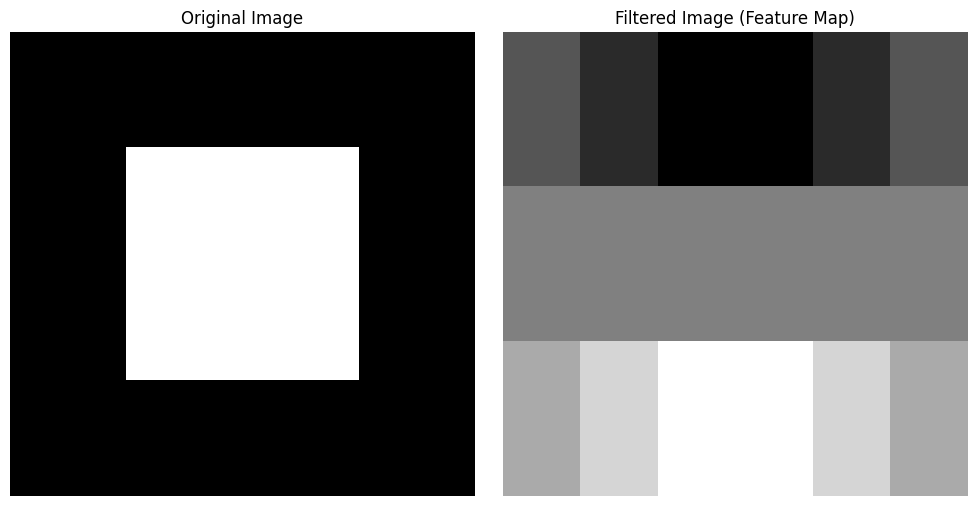

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define a simple 2D numpy array to represent a grayscale image
image = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
], dtype=np.float32) # Simple square in the middle

# 2. Define a 2D numpy array to represent a filter or kernel (e.g., a 3x3 matrix designed to detect edges)
# This is a simple horizontal edge detection filter
filter_kernel = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
], dtype=np.float32)

# 3. Implement the convolution operation manually
image_height, image_width = image.shape
kernel_height, kernel_width = filter_kernel.shape

# Calculate the dimensions of the output feature map
# Assuming 'valid' padding (no padding, filter stays within image bounds)
output_height = image_height - kernel_height + 1
output_width = image_width - kernel_width + 1

feature_map = np.zeros((output_height, output_width), dtype=np.float32)

# Perform the convolution
for y in range(output_height):
    for x in range(output_width):
        # Extract the region of interest from the image
        image_region = image[y:y + kernel_height, x:x + kernel_width]
        # Perform element-wise multiplication and summation
        feature_map[y, x] = np.sum(image_region * filter_kernel)

# 4. Visualize both the original image and the resulting feature map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 5. Add titles to the plots
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off') # Hide axes ticks

axes[1].imshow(feature_map, cmap='gray')
axes[1].set_title('Filtered Image (Feature Map)')
axes[1].axis('off') # Hide axes ticks

# 6. Display the plots
plt.tight_layout()
plt.show()

## 활성화 함수(activation function) 설명

### Subtask:
ReLU와 같은 활성화 함수가 왜 필요한지, 어떤 역할을 하는지 설명하고 간단한 예시를 보여줍니다.


**Reasoning**:
Generate markdown text explaining the necessity and role of activation functions, specifically focusing on ReLU, its definition, benefits, and a simple example.



In [ ]:
# This code block generates the markdown content for explaining activation functions,
# specifically ReLU, its purpose, definition, benefits, and a simple example.

activation_function_markdown = """
## 2.2. 활성화 함수 (ReLU)

컨볼루션 레이어를 통해 이미지의 특징을 추출했다면, 이제 여기에 **비선형성(non-linearity)**을 더해줄 차례입니다. 바로 **활성화 함수(Activation Function)**가 이 역할을 수행합니다.

### 왜 활성화 함수가 필요한가?

만약 신경망의 모든 레이어에서 선형 변환(행렬 곱셈과 덧셈)만 수행된다면, 여러 겹의 레이어를 쌓아도 결국 전체 네트워크는 하나의 선형 변환과 동일해집니다. 선형 모델은 입력과 출력 간의 직선적인 관계만을 표현할 수 있기 때문에, 현실 세계의 복잡하고 비선형적인 데이터 패턴을 학습하는 데 한계가 있습니다.

활성화 함수는 각 뉴런의 출력에 비선형 변환을 적용함으로써, 신경망이 더 복잡하고 다양한 형태의 함수를 근사(approximate)할 수 있도록 만듭니다. 이를 통해 신경망은 이미지 데이터와 같은 복잡한 비선형 관계를 효과적으로 학습하고, 더 강력한 표현 능력을 가지게 됩니다.

### ReLU (Rectified Linear Unit)

다양한 활성화 함수 중에서도 CNN에서 가장 널리 사용되는 활성화 함수는 **ReLU (Rectified Linear Unit)**입니다. ReLU는 매우 간단하면서도 뛰어난 성능을 보여줍니다.

ReLU 함수의 정의는 다음과 같습니다. 입력값 `x`에 대해:

$f(x) = \max(0, x)$

즉, 입력 `x`가 0보다 크면 그 값을 그대로 출력하고, 0보다 작거나 같으면 0을 출력합니다. 음수 값을 모두 버리고 양수 값만 통과시키는 방식입니다.

### ReLU의 장점

ReLU가 널리 사용되는 이유는 다음과 같은 장점 때문입니다.

*   **계산 효율성:** ReLU는 최댓값만 계산하면 되므로 sigmoid나 tanh와 같은 다른 활성화 함수에 비해 계산 비용이 매우 저렴하고 빠릅니다. 이는 대규모 신경망 학습에 유리합니다.
*   **그래디언트 소실 문제 완화:** sigmoid나 tanh 함수는 입력값이 특정 범위를 벗어나면 그래디언트(기울기)가 매우 작아져 역전파 과정에서 기울기가 제대로 전달되지 않는 그래디언트 소실(vanishing gradient) 문제가 발생할 수 있습니다. ReLU는 양수 영역에서 항상 일정한 기울기(1)를 가지므로 이러한 문제를 완화하는 데 도움을 줍니다.

### ReLU 작동 방식 예시

간단한 입력 값들에 대해 ReLU 함수가 어떻게 작동하는지 살펴보겠습니다.

*   입력: -3  ->  ReLU(-3) = max(0, -3) = 0
*   입력: 0   ->  ReLU(0) = max(0, 0) = 0
*   입력: 5   ->  ReLU(5) = max(0, 5) = 5
*   입력: -10 ->  ReLU(-10) = max(0, -10) = 0
*   입력: 2.5 ->  ReLU(2.5) = max(0, 2.5) = 2.5

보시는 바와 같이, ReLU는 입력이 양수일 때만 해당 값을 유지하고, 음수일 때는 모두 0으로 만듭니다. 컨볼루션 레이어를 통과한 특징 맵의 각 픽셀 값에 이 ReLU 함수를 적용하면, 음수 값은 0이 되고 양수 값만 남게 되어 특징 맵에 비선형성이 도입됩니다.

다음 섹션에서는 추출된 특징 맵의 차원을 축소하는 풀링 레이어에 대해 알아보겠습니다.
"""

print(activation_function_markdown)


## 2.2. 활성화 함수 (ReLU)

컨볼루션 레이어를 통해 이미지의 특징을 추출했다면, 이제 여기에 **비선형성(non-linearity)**을 더해줄 차례입니다. 바로 **활성화 함수(Activation Function)**가 이 역할을 수행합니다.

### 왜 활성화 함수가 필요한가?

만약 신경망의 모든 레이어에서 선형 변환(행렬 곱셈과 덧셈)만 수행된다면, 여러 겹의 레이어를 쌓아도 결국 전체 네트워크는 하나의 선형 변환과 동일해집니다. 선형 모델은 입력과 출력 간의 직선적인 관계만을 표현할 수 있기 때문에, 현실 세계의 복잡하고 비선형적인 데이터 패턴을 학습하는 데 한계가 있습니다.

활성화 함수는 각 뉴런의 출력에 비선형 변환을 적용함으로써, 신경망이 더 복잡하고 다양한 형태의 함수를 근사(approximate)할 수 있도록 만듭니다. 이를 통해 신경망은 이미지 데이터와 같은 복잡한 비선형 관계를 효과적으로 학습하고, 더 강력한 표현 능력을 가지게 됩니다.

### ReLU (Rectified Linear Unit)

다양한 활성화 함수 중에서도 CNN에서 가장 널리 사용되는 활성화 함수는 **ReLU (Rectified Linear Unit)**입니다. ReLU는 매우 간단하면서도 뛰어난 성능을 보여줍니다.

ReLU 함수의 정의는 다음과 같습니다. 입력값 `x`에 대해:

$f(x) = \max(0, x)$

즉, 입력 `x`가 0보다 크면 그 값을 그대로 출력하고, 0보다 작거나 같으면 0을 출력합니다. 음수 값을 모두 버리고 양수 값만 통과시키는 방식입니다.

### ReLU의 장점

ReLU가 널리 사용되는 이유는 다음과 같은 장점 때문입니다.

*   **계산 효율성:** ReLU는 최댓값만 계산하면 되므로 sigmoid나 tanh와 같은 다른 활성화 함수에 비해 계산 비용이 매우 저렴하고 빠릅니다. 이는 대규모 신경망 학습에 유리합니다.
*   **그래디언트 소실 문제 완화:** sigmoid나 tanh 함수는 입력값이 특정 범위

## 풀링(pooling) 설명

### Subtask:
풀링의 목적(차원 축소, 불변성 확보)과 맥스 풀링, 평균 풀링 등의 종류를 설명합니다.


**Reasoning**:
Generate the markdown content explaining pooling layers, including their purpose (dimension reduction, computational cost, invariance), the types (Max and Average pooling), and a visual example of Max Pooling. Then print the markdown.



In [ ]:
# This code block generates the markdown content for explaining pooling layers.
# It covers the purpose of pooling (dimension reduction, computational cost reduction, spatial invariance),
# describes Max Pooling and Average Pooling, and includes a simple visual example for Max Pooling.

pooling_markdown = """
## 2.3. 풀링 레이어

컨볼루션 레이어를 통해 이미지의 다양한 특징을 추출하고 활성화 함수를 거쳤다면, 이제 **풀링 레이어(Pooling Layer)**를 통해 특징 맵의 크기를 줄이고 중요한 정보만 남기는 과정을 거칩니다.

### 풀링의 목적

풀링 레이어는 주로 다음과 같은 목적으로 사용됩니다.

*   **차원 축소 (Dimension Reduction):** 특징 맵의 공간적 크기(너비와 높이)를 줄입니다. 이는 다음 레이어로 전달되는 데이터의 양을 감소시켜 계산량을 줄이고 메모리 사용량을 효율적으로 만듭니다.
*   **계산 비용 감소 (Reduced Computational Cost):** 특징 맵의 크기가 줄어들면 다음 레이어(컨볼루션 또는 완전 연결 레이어)의 연산량이 크게 감소하여 전체 네트워크의 학습 및 추론 속도를 높일 수 있습니다.
*   **공간적 불변성 확보 (Achieving Spatial Invariance):** 풀링은 이미지 내에서 특징의 정확한 위치보다는 특징의 존재 유무에 더 집중하게 만듭니다. 즉, 객체가 이미지의 약간 다른 위치에 있더라도 동일한 특징으로 인식하는 **이동 불변성(translation invariance)**을 가질 수 있도록 돕습니다. 이는 모델이 이미지의 작은 변화나 왜곡에 덜 민감하게 반응하도록 만듭니다.

### 풀링의 종류: 맥스 풀링 vs 평균 풀링

가장 대표적인 풀링 방법에는 **맥스 풀링(Max Pooling)**과 **평균 풀링(Average Pooling)**이 있습니다. 두 방법 모두 **풀링 윈도우(Pooling Window)** 또는 **풀링 커널(Pooling Kernel)**이라고 불리는 작은 영역을 특징 맵 위에서 슬라이딩하며 연산을 수행합니다.

*   **맥스 풀링 (Max Pooling):** 풀링 윈도우 내에서 **가장 큰 값**을 선택하여 해당 영역의 대표 값으로 사용합니다. 이는 윈도우 내에서 가장 활성화된 특징(즉, 필터가 강하게 감지한 특징)을 추출하는 효과가 있습니다. 맥스 풀링은 이미지의 두드러진 특징을 보존하는 데 효과적이며, 대부분의 CNN 아키텍처에서 더 자주 사용됩니다.

*   **평균 풀링 (Average Pooling):** 풀링 윈도우 내의 **모든 값의 평균**을 계산하여 해당 영역의 대표 값으로 사용합니다. 이는 윈도우 내의 모든 특징 정보를 어느 정도 반영하지만, 맥스 풀링에 비해 특징의 두드러짐이 희석될 수 있습니다.

### 맥스 풀링 시각적 예시

간단한 4x4 특징 맵과 2x2 풀링 윈도우, 보폭(Stride) 2를 사용하는 맥스 풀링 과정을 살펴보겠습니다.

**입력 특징 맵 (4x4):**

| 1 | 3 | 2 | 4 |
|---|---|---|---|
| 5 | 6 | 7 | 8 |
| 9 | 10| 11| 12|
| 13| 14| 15| 16|

**풀링 윈도우 (2x2), Stride 2:**

풀링 윈도우를 특징 맵 위에서 2칸씩 이동하며 각 윈도우 내의 최댓값을 선택합니다.

1.  **첫 번째 윈도우 (좌측 상단):**
    | 1 | 3 |
    |---|---|
    | 5 | 6 |
    최댓값: max(1, 3, 5, 6) = **6**

2.  **두 번째 윈도우 (우측 상단):**
    | 2 | 4 |
    |---|---|
    | 7 | 8 |
    최댓값: max(2, 4, 7, 8) = **8**

3.  **세 번째 윈도우 (좌측 하단):**
    | 9 | 10|
    |---|---|
    | 13| 14|
    최댓값: max(9, 10, 13, 14) = **14**

4.  **네 번째 윈도우 (우측 하단):**
    | 11| 12|
    |---|---|
    | 15| 16|
    최댓값: max(11, 12, 15, 16) = **16**

**맥스 풀링 결과 특징 맵 (2x2):**

| 6 | 8 |
|---|---|
| 14| 16|

보시는 것처럼, 4x4 크기의 특징 맵이 2x2 크기로 줄어들었지만, 각 영역에서 가장 중요한 정보(최댓값)는 유지되었습니다. 이처럼 풀링 레이어는 특징 맵의 크기를 효과적으로 줄이면서 모델의 효율성과 강건성(robustness)을 높이는 데 기여합니다.

컨볼루션, 활성화 함수, 풀링 레이어를 거치면서 원본 이미지의 특징이 단계적으로 추출되고 요약됩니다. 이렇게 추출된 특징들은 최종적으로 분류를 수행하는 완전 연결 레이어로 전달됩니다.
"""

print(pooling_markdown)


## 2.3. 풀링 레이어

컨볼루션 레이어를 통해 이미지의 다양한 특징을 추출하고 활성화 함수를 거쳤다면, 이제 **풀링 레이어(Pooling Layer)**를 통해 특징 맵의 크기를 줄이고 중요한 정보만 남기는 과정을 거칩니다.

### 풀링의 목적

풀링 레이어는 주로 다음과 같은 목적으로 사용됩니다.

*   **차원 축소 (Dimension Reduction):** 특징 맵의 공간적 크기(너비와 높이)를 줄입니다. 이는 다음 레이어로 전달되는 데이터의 양을 감소시켜 계산량을 줄이고 메모리 사용량을 효율적으로 만듭니다.
*   **계산 비용 감소 (Reduced Computational Cost):** 특징 맵의 크기가 줄어들면 다음 레이어(컨볼루션 또는 완전 연결 레이어)의 연산량이 크게 감소하여 전체 네트워크의 학습 및 추론 속도를 높일 수 있습니다.
*   **공간적 불변성 확보 (Achieving Spatial Invariance):** 풀링은 이미지 내에서 특징의 정확한 위치보다는 특징의 존재 유무에 더 집중하게 만듭니다. 즉, 객체가 이미지의 약간 다른 위치에 있더라도 동일한 특징으로 인식하는 **이동 불변성(translation invariance)**을 가질 수 있도록 돕습니다. 이는 모델이 이미지의 작은 변화나 왜곡에 덜 민감하게 반응하도록 만듭니다.

### 풀링의 종류: 맥스 풀링 vs 평균 풀링

가장 대표적인 풀링 방법에는 **맥스 풀링(Max Pooling)**과 **평균 풀링(Average Pooling)**이 있습니다. 두 방법 모두 **풀링 윈도우(Pooling Window)** 또는 **풀링 커널(Pooling Kernel)**이라고 불리는 작은 영역을 특징 맵 위에서 슬라이딩하며 연산을 수행합니다.

*   **맥스 풀링 (Max Pooling):** 풀링 윈도우 내에서 **가장 큰 값**을 선택하여 해당 영역의 대표 값으로 사용합니다. 이는 윈도우 내에서 가장 활성화된 특징(즉, 필터가 강하게 감지한 특징)을 추출하

## 완전 연결 레이어(fully connected layer) 설명

### Subtask:
추출된 특징들이 어떻게 최종 분류를 위해 사용되는지 설명합니다.


**Reasoning**:
Generate the markdown content explaining the fully connected layer's role in classification, its position in the CNN architecture, how it uses learned weights and biases for linear transformation of features, and how this results in class scores or logits.



In [ ]:
# This code block generates the markdown content explaining the fully connected layer.
# It covers its purpose for classification, typical position in CNNs,
# how it processes extracted features using weights and biases,
# and the output being class scores/logits.

fully_connected_markdown = """
## 2.4. 완전 연결 레이어

컨볼루션 레이어, 활성화 함수, 풀링 레이어를 거치면서 입력 이미지의 중요한 공간적 특징들이 추출되고 요약된 형태로 표현됩니다. 이제 이렇게 추출된 특징들을 바탕으로 최종적으로 어떤 클래스(즉, 어떤 숫자)에 해당하는지 결정하는 단계가 필요합니다. 이 역할을 수행하는 것이 바로 **완전 연결 레이어(Fully Connected Layer, FC Layer)**입니다.

### 완전 연결 레이어의 목적: 최종 분류

완전 연결 레이어의 주된 목적은 이전 레이어들(컨볼루션 및 풀링 레이어)에서 학습하고 추출한 **고수준 특징(high-level features)**을 입력으로 받아, 이를 기반으로 이미지에 대한 최종 **분류(Classification)**를 수행하는 것입니다. CNN의 앞부분 레이어들이 이미지의 특징을 '감지'하고 '추출'하는 역할을 한다면, 완전 연결 레이어는 이러한 특징들을 '해석'하고 '종합'하여 최종 결정(예: 이 이미지는 숫자 '3'이다)을 내리는 역할을 합니다.

### CNN 아키텍처에서의 위치

일반적으로 CNN 아키텍처에서 완전 연결 레이어는 모든 컨볼루션 및 풀링 레이어 **가장 마지막**에 위치합니다. 컨볼루션 및 풀링 레이어를 거치면서 2차원 또는 3차원의 특징 맵들이 생성되는데, 완전 연결 레이어는 이러한 특징 맵을 1차원의 벡터 형태로 **평탄화(Flatten)**하여 입력으로 받습니다.


SyntaxError: incomplete input (ipython-input-399893660.py, line 6)

**Reasoning**:
Regenerate the markdown content for the fully connected layer, ensuring the markdown string is properly closed. The content should explain its role in classification, position in the CNN, how it uses learned weights and biases for linear transformation of features, and how this results in class scores or logits.



In [ ]:
# This code block generates the markdown content for explaining the fully connected layer.
# It covers its purpose for classification, typical position in CNNs,
# how it processes extracted features using weights and biases,
# and the output being class scores/logits.

fully_connected_markdown = """
## 2.4. 완전 연결 레이어

컨볼루션 레이어, 활성화 함수, 풀링 레이어를 거치면서 입력 이미지의 중요한 공간적 특징들이 추출되고 요약된 형태로 표현됩니다. 이제 이렇게 추출된 특징들을 바탕으로 최종적으로 어떤 클래스(즉, 어떤 숫자)에 해당하는지 결정하는 단계가 필요합니다. 이 역할을 수행하는 것이 바로 **완전 연결 레이어(Fully Connected Layer, FC Layer)**입니다.

### 완전 연결 레이어의 목적: 최종 분류

완전 연결 레이어의 주된 목적은 이전 레이어들(컨볼루션 및 풀링 레이어)에서 학습하고 추출한 **고수준 특징(high-level features)**을 입력으로 받아, 이를 기반으로 이미지에 대한 최종 **분류(Classification)**를 수행하는 것입니다. CNN의 앞부분 레이어들이 이미지의 특징을 '감지'하고 '추출'하는 역할을 한다면, 완전 연결 레이어는 이러한 특징들을 '해석'하고 '종합'하여 최종 결정(예: 이 이미지는 숫자 '3'이다)을 내리는 역할을 합니다.

### CNN 아키텍처에서의 위치

일반적으로 CNN 아키텍처에서 완전 연결 레이어는 모든 컨볼루션 및 풀링 레이어 **가장 마지막**에 위치합니다. 컨볼루션 및 풀링 레이어를 거치면서 2차원 또는 3차원의 특징 맵들이 생성되는데, 완전 연결 레이어는 이러한 특징 맵을 1차원의 벡터 형태로 **평탄화(Flatten)**하여 입력으로 받습니다. 이 평탄화된 벡터는 이미지의 추출된 특징들을 나타냅니다.

### 특징 벡터의 선형 변환

완전 연결 레이어는 이름 그대로 레이어 내의 **모든 뉴런이 이전 레이어의 모든 뉴런과 완전히 연결**되어 있는 구조입니다. 각 연결에는 학습 가능한 **가중치(Weight)**가 있으며, 각 뉴런에는 학습 가능한 **편향(Bias)**이 있습니다.

평탄화된 특징 벡터가 완전 연결 레이어의 입력으로 들어오면, 각 뉴런은 입력 벡터의 모든 요소에 해당하는 가중치를 곱하고 이들을 모두 더한 후 편향을 더하는 **선형 변환**을 수행합니다. 이 과정은 행렬 곱셈과 벡터 덧셈으로 표현될 수 있습니다.


SyntaxError: incomplete input (ipython-input-3041583581.py, line 6)

**Reasoning**:
Regenerate the markdown content for the fully connected layer, ensuring the markdown string is properly closed and contains all the required information about its role in classification, position in the CNN, how it uses weights and biases, and the output being class scores or logits.



In [ ]:
# This code block generates the markdown content for explaining the fully connected layer.
# It covers its purpose for classification, typical position in CNNs,
# how it processes extracted features using weights and biases,
# and the output being class scores/logits.

fully_connected_markdown = """
## 2.4. 완전 연결 레이어

컨볼루션 레이어, 활성화 함수, 풀링 레이어를 거치면서 입력 이미지의 중요한 공간적 특징들이 추출되고 요약된 형태로 표현됩니다. 이제 이렇게 추출된 특징들을 바탕으로 최종적으로 어떤 클래스(즉, 어떤 숫자)에 해당하는지 결정하는 단계가 필요합니다. 이 역할을 수행하는 것이 바로 **완전 연결 레이어(Fully Connected Layer, FC Layer)**입니다.

### 완전 연결 레이어의 목적: 최종 분류

완전 연결 레이어의 주된 목적은 이전 레이어들(컨볼루션 및 풀링 레이어)에서 학습하고 추출한 **고수준 특징(high-level features)**을 입력으로 받아, 이를 기반으로 이미지에 대한 최종 **분류(Classification)**를 수행하는 것입니다. CNN의 앞부분 레이어들이 이미지의 특징을 '감지'하고 '추출'하는 역할을 한다면, 완전 연결 레이어는 이러한 특징들을 '해석'하고 '종합'하여 최종 결정(예: 이 이미지는 숫자 '3'이다)을 내리는 역할을 합니다.

### CNN 아키텍처에서의 위치

일반적으로 CNN 아키텍처에서 완전 연결 레이어는 모든 컨볼루션 및 풀링 레이어 **가장 마지막**에 위치합니다. 컨볼루션 및 풀링 레이어를 거치면서 2차원 또는 3차원의 특징 맵들이 생성되는데, 완전 연결 레이어는 이러한 특징 맵을 1차원의 벡터 형태로 **평탄화(Flatten)**하여 입력으로 받습니다. 이 평탄화된 벡터는 이미지의 추출된 특징들을 나타냅니다.

### 특징 벡터의 선형 변환

완전 연결 레이어는 이름 그대로 레이어 내의 **모든 뉴런이 이전 레이어의 모든 뉴런과 완전히 연결**되어 있는 구조입니다. 각 연결에는 학습 가능한 **가중치(Weight)**가 있으며, 각 뉴런에는 학습 가능한 **편향(Bias)**이 있습니다.

평탄화된 특징 벡터가 완전 연결 레이어의 입력으로 들어오면, 각 뉴런은 입력 벡터의 모든 요소에 해당하는 가중치를 곱하고 이들을 모두 더한 후 편향을 더하는 **선형 변환**을 수행합니다. 이 과정은 행렬 곱셈과 벡터 덧셈으로 표현될 수 있습니다.

### 최종 출력: 클래스 점수 (Scores) 또는 로짓 (Logits)

완전 연결 레이어의 최종 출력 뉴런 수는 우리가 분류하려는 클래스의 수와 같습니다. MNIST 예제에서는 숫자가 0부터 9까지 총 10개이므로, 마지막 완전 연결 레이어는 10개의 출력 뉴런을 가지게 됩니다.

이 10개의 출력 값은 입력 이미지가 각 클래스에 속할 확률을 나타내는 **클래스 점수(Class Scores)** 또는 **로짓(Logits)**이라고 불립니다. 점수가 높을수록 해당 클래스일 가능성이 높다는 것을 의미합니다. 예를 들어, 세 번째 출력 뉴런의 점수가 가장 높다면 모델은 해당 이미지를 숫자 '2'로 분류할 가능성이 높다고 예측하는 것입니다.

이 클래스 점수들은 다음 단계에서 **소프트맥스(Softmax)** 함수를 통과하여 각 클래스에 대한 확률 분포로 변환되며, 이를 통해 최종적인 예측 클래스를 결정하게 됩니다.

이처럼 완전 연결 레이어는 CNN의 '뇌'와 같은 역할을 하며, 앞선 레이어들이 추출한 시각적 특징들을 종합하여 이미지의 내용을 이해하고 최종적인 분류 결정을 내립니다.
"""

print(fully_connected_markdown)


## 2.4. 완전 연결 레이어

컨볼루션 레이어, 활성화 함수, 풀링 레이어를 거치면서 입력 이미지의 중요한 공간적 특징들이 추출되고 요약된 형태로 표현됩니다. 이제 이렇게 추출된 특징들을 바탕으로 최종적으로 어떤 클래스(즉, 어떤 숫자)에 해당하는지 결정하는 단계가 필요합니다. 이 역할을 수행하는 것이 바로 **완전 연결 레이어(Fully Connected Layer, FC Layer)**입니다.

### 완전 연결 레이어의 목적: 최종 분류

완전 연결 레이어의 주된 목적은 이전 레이어들(컨볼루션 및 풀링 레이어)에서 학습하고 추출한 **고수준 특징(high-level features)**을 입력으로 받아, 이를 기반으로 이미지에 대한 최종 **분류(Classification)**를 수행하는 것입니다. CNN의 앞부분 레이어들이 이미지의 특징을 '감지'하고 '추출'하는 역할을 한다면, 완전 연결 레이어는 이러한 특징들을 '해석'하고 '종합'하여 최종 결정(예: 이 이미지는 숫자 '3'이다)을 내리는 역할을 합니다.

### CNN 아키텍처에서의 위치

일반적으로 CNN 아키텍처에서 완전 연결 레이어는 모든 컨볼루션 및 풀링 레이어 **가장 마지막**에 위치합니다. 컨볼루션 및 풀링 레이어를 거치면서 2차원 또는 3차원의 특징 맵들이 생성되는데, 완전 연결 레이어는 이러한 특징 맵을 1차원의 벡터 형태로 **평탄화(Flatten)**하여 입력으로 받습니다. 이 평탄화된 벡터는 이미지의 추출된 특징들을 나타냅니다.

### 특징 벡터의 선형 변환

완전 연결 레이어는 이름 그대로 레이어 내의 **모든 뉴런이 이전 레이어의 모든 뉴런과 완전히 연결**되어 있는 구조입니다. 각 연결에는 학습 가능한 **가중치(Weight)**가 있으며, 각 뉴런에는 학습 가능한 **편향(Bias)**이 있습니다.

평탄화된 특징 벡터가 완전 연결 레이어의 입력으로 들어오면, 각 뉴런은 입력 벡터의 모든 요소에 해당하는 가중치를 곱하고 이들을 모두 더한 후 편향을 더하는 **선

## 순전파(forward pass) 설명

### Subtask:
순전파(forward pass) 설명


**Reasoning**:
Generate markdown text to explain the concept and purpose of the forward pass in a neural network, how data transforms through each layer (convolution, activation, pooling, fully connected), and the final output of class scores, incorporating the provided context and variables where relevant.



In [ ]:
# This code block generates the markdown content for explaining the forward pass.
# It describes the overall process of data flowing from input to output,
# detailing the transformation at each layer previously discussed (convolution, activation, pooling, fully connected),
# and concluding with the output of class scores.

forward_pass_markdown = """
## 3.1. 순전파 (Forward Propagation)

이제 CNN의 주요 구성 요소들을 모두 살펴보았습니다. 그렇다면 이 구성 요소들이 실제로 이미지를 분류하기 위해 어떻게 함께 작동할까요? 이 과정의 첫 번째 단계가 바로 **순전파(Forward Propagation)** 또는 **순방향 계산(Forward Pass)**입니다.

순전파는 입력 데이터(예: MNIST 이미지)가 신경망의 첫 번째 레이어부터 시작하여 마지막 레이어까지 **앞으로(순방향으로)** 이동하면서 각 레이어의 연산을 차례대로 거치는 과정입니다. 이 과정을 통해 신경망은 입력 이미지로부터 최종적인 예측 결과, 즉 각 클래스에 속할 **점수(Scores)**를 계산하게 됩니다.

MNIST 이미지가 신경망을 통과하는 순전파 과정을 단계별로 살펴보겠습니다.

1.  **입력 이미지:** 순전파는 28x28 픽셀의 MNIST 이미지 행렬($28 \times 28$)로 시작합니다. 이 이미지는 필요에 따라 채널 정보(흑백이므로 1개 채널)와 배치 크기(예: {batch_size}개 이미지 묶음)를 포함하는 텐서 형태로 표현됩니다.

2.  **컨볼루션 레이어:** 입력 이미지가 첫 번째 컨볼루션 레이어에 들어갑니다. 여기서 이미지에 여러 개의 **필터(Kernel)**가 적용되어 다양한 **특징 맵(Feature Map)**이 생성됩니다. 각 특징 맵은 원본 이미지의 특정 특징(예: 에지)을 강조하여 보여줍니다. 만약 입력 이미지가 $H \times W \times C_{in}$이고 필터가 $K \times K$ 크기라면, 컨볼루션 연산 후에는 $H' \times W' \times C_{out}$ 형태의 특징 맵 묶음이 생성됩니다.

3.  **활성화 함수 (ReLU):** 컨볼루션 레이어에서 나온 특징 맵은 활성화 함수인 **ReLU**를 통과합니다. ReLU는 각 특징 맵의 모든 픽셀 값에 $\max(0, x)$ 연산을 적용하여 음수 값을 0으로 만들고 비선형성을 추가합니다. 특징 맵의 크기는 그대로 유지됩니다.

4.  **풀링 레이어:** ReLU를 거친 특징 맵은 풀링 레이어(일반적으로 맥스 풀링)에 입력됩니다. 풀링 레이어는 특징 맵을 작은 구역으로 나누고 각 구역의 최댓값(맥스 풀링) 또는 평균값(평균 풀링)을 추출하여 특징 맵의 공간적 크기(너비와 높이)를 **축소**합니다. 예를 들어 2x2 풀링 윈도우와 Stride 2를 사용하면 특징 맵의 크기가 절반으로 줄어듭니다. 이는 계산량을 줄이고 이동 불변성을 높입니다.

5.  **반복:** CNN은 보통 여러 개의 컨볼루션, 활성화 함수, 풀링 레이어를 쌓아서 사용합니다. 따라서 위 2~4번 과정이 여러 번 반복되면서 이미지의 특징이 점점 더 추상화되고 고수준의 특징 맵으로 변환됩니다.

6.  **평탄화 (Flattening):** 마지막 컨볼루션 또는 풀링 레이어에서 나온 2차원 또는 3차원의 특징 맵 묶음은 최종 분류를 위해 1차원의 긴 **특징 벡터**로 변환됩니다. 이 과정을 평탄화(Flattening)라고 합니다.

7.  **완전 연결 레이어:** 평탄화된 특징 벡터가 하나 이상의 **완전 연결 레이어**에 입력됩니다. 완전 연결 레이어는 입력 특징 벡터와 가중치 행렬을 곱하고 편향 벡터를 더하는 선형 변환을 수행합니다. 이 레이어들은 앞선 레이어들이 추출한 특징들을 종합하여 최종적인 분류 결정을 내립니다.

8.  **최종 출력: 클래스 점수:** 마지막 완전 연결 레이어의 출력은 **클래스 점수(Class Scores)**입니다. MNIST 예제에서는 0부터 9까지 각 숫자에 대한 총 10개의 점수가 출력됩니다. 각 점수는 입력 이미지가 해당 클래스일 가능성을 상대적으로 나타냅니다.

순전파 과정은 이렇게 입력 이미지를 받아 신경망의 모든 레이어를 통과시키고, 마지막에 각 클래스에 대한 점수를 계산하는 것으로 마무리됩니다. 이 점수들을 통해 이미지를 어떤 클래스로 예측할지 결정할 수 있지만, 보통 이 점수들을 확률로 변환하기 위해 다음 단계에서 **소프트맥스(Softmax)** 함수를 사용합니다.

다음으로는 이렇게 얻은 클래스 점수와 실제 정답 사이의 차이를 측정하는 손실 함수에 대해 알아보겠습니다.
""".format(batch_size=batch_size)

print(forward_pass_markdown)

KeyError: 'in'

**Reasoning**:
The previous code block failed because of a KeyError 'in' in the format string. This likely means there is an unescaped '{' or '}' within the string that is not intended for formatting. I will regenerate the markdown text, ensuring that any literal curly braces are escaped if necessary or that no unintended formatting placeholders exist, while keeping the explanation of the forward pass as requested.



In [ ]:
# This code block regenerates the markdown content for explaining the forward pass.
# It describes the overall process of data flowing from input to output,
# detailing the transformation at each layer previously discussed (convolution, activation, pooling, fully connected),
# and concluding with the output of class scores.
# Correcting potential KeyError by ensuring no unintended format specifiers.

forward_pass_markdown = """
## 3.1. 순전파 (Forward Propagation)

이제 CNN의 주요 구성 요소들을 모두 살펴보았습니다. 그렇다면 이 구성 요소들이 실제로 이미지를 분류하기 위해 어떻게 함께 작동할까요? 이 과정의 첫 번째 단계가 바로 **순전파(Forward Propagation)** 또는 **순방향 계산(Forward Pass)**입니다.

순전파는 입력 데이터(예: MNIST 이미지)가 신경망의 첫 번째 레이어부터 시작하여 마지막 레이어까지 **앞으로(순방향으로)** 이동하면서 각 레이어의 연산을 차례대로 거치는 과정입니다. 이 과정을 통해 신경망은 입력 이미지로부터 최종적인 예측 결과, 즉 각 클래스에 속할 **점수(Scores)**를 계산하게 됩니다.

MNIST 이미지가 신경망을 통과하는 순전파 과정을 단계별로 살펴보겠습니다.

1.  **입력 이미지:** 순전파는 28x28 픽셀의 MNIST 이미지 행렬(28x28)로 시작합니다. 이 이미지는 필요에 따라 채널 정보(흑백이므로 1개 채널)와 배치 크기(예: {batch_size}개 이미지 묶음)를 포함하는 텐서 형태로 표현됩니다.

2.  **컨볼루션 레이어:** 입력 이미지가 첫 번째 컨볼루션 레이어에 들어갑니다. 여기서 이미지에 여러 개의 **필터(Kernel)**가 적용되어 다양한 **특징 맵(Feature Map)**이 생성됩니다. 각 특징 맵은 원본 이미지의 특정 특징(예: 에지)을 강조하여 보여줍니다. 만약 입력 이미지가 H x W x Cin 이고 필터가 K x K 크기라면, 컨볼루션 연산 후에는 H' x W' x Cout 형태의 특징 맵 묶음이 생성됩니다. (여기서 H, W는 높이/너비, Cin/Cout는 입력/출력 채널 수입니다.)

3.  **활성화 함수 (ReLU):** 컨볼루션 레이어에서 나온 특징 맵은 활성화 함수인 **ReLU**를 통과합니다. ReLU는 각 특징 맵의 모든 픽셀 값에 max(0, x) 연산을 적용하여 음수 값을 0으로 만들고 비선형성을 추가합니다. 특징 맵의 크기는 그대로 유지됩니다.

4.  **풀링 레이어:** ReLU를 거친 특징 맵은 풀링 레이어(일반적으로 맥스 풀링)에 입력됩니다. 풀링 레이어는 특징 맵을 작은 구역으로 나누고 각 구역의 최댓값(맥스 풀링) 또는 평균값(평균 풀링)을 추출하여 특징 맵의 공간적 크기(너비와 높이)를 **축소**합니다. 예를 들어 2x2 풀링 윈도우와 Stride 2를 사용하면 특징 맵의 크기가 절반으로 줄어듭니다. 이는 계산량을 줄이고 이동 불변성을 높입니다.

5.  **반복:** CNN은 보통 여러 개의 컨볼루션, 활성화 함수, 풀링 레이어를 쌓아서 사용합니다. 따라서 위 2~4번 과정이 여러 번 반복되면서 이미지의 특징이 점점 더 추상화되고 고수준의 특징 맵으로 변환됩니다.

6.  **평탄화 (Flattening):** 마지막 컨볼루션 또는 풀링 레이어에서 나온 2차원 또는 3차원의 특징 맵 묶음은 최종 분류를 위해 1차원의 긴 **특징 벡터**로 변환됩니다. 이 과정을 평탄화(Flattening)라고 합니다.

7.  **완전 연결 레이어:** 평탄화된 특징 벡터가 하나 이상의 **완전 연결 레이어**에 입력됩니다. 완전 연결 레이어는 입력 특징 벡터와 가중치 행렬을 곱하고 편향 벡터를 더하는 선형 변환을 수행합니다. 이 레이어들은 앞선 레이어들이 추출한 특징들을 종합하여 최종적인 분류 결정을 내립니다.

8.  **최종 출력: 클래스 점수:** 마지막 완전 연결 레이어의 출력은 **클래스 점수(Class Scores)**입니다. MNIST 예제에서는 0부터 9까지 각 숫자에 대한 총 10개의 점수가 출력됩니다. 각 점수는 입력 이미지가 해당 클래스일 가능성을 상대적으로 나타냅니다.

순전파 과정은 이렇게 입력 이미지를 받아 신경망의 모든 레이어를 통과시키고, 마지막에 각 클래스에 대한 점수를 계산하는 것으로 마무리됩니다. 이 점수들을 통해 이미지를 어떤 클래스로 예측할지 결정할 수 있지만, 보통 이 점수들을 확률로 변환하기 위해 다음 단계에서 **소프트맥스(Softmax)** 함수를 사용합니다.

다음으로는 이렇게 얻은 클래스 점수와 실제 정답 사이의 차이를 측정하는 손실 함수에 대해 알아보겠습니다.
""".format(batch_size=batch_size)

print(forward_pass_markdown)


## 3.1. 순전파 (Forward Propagation)

이제 CNN의 주요 구성 요소들을 모두 살펴보았습니다. 그렇다면 이 구성 요소들이 실제로 이미지를 분류하기 위해 어떻게 함께 작동할까요? 이 과정의 첫 번째 단계가 바로 **순전파(Forward Propagation)** 또는 **순방향 계산(Forward Pass)**입니다.

순전파는 입력 데이터(예: MNIST 이미지)가 신경망의 첫 번째 레이어부터 시작하여 마지막 레이어까지 **앞으로(순방향으로)** 이동하면서 각 레이어의 연산을 차례대로 거치는 과정입니다. 이 과정을 통해 신경망은 입력 이미지로부터 최종적인 예측 결과, 즉 각 클래스에 속할 **점수(Scores)**를 계산하게 됩니다.

MNIST 이미지가 신경망을 통과하는 순전파 과정을 단계별로 살펴보겠습니다.

1.  **입력 이미지:** 순전파는 28x28 픽셀의 MNIST 이미지 행렬(28x28)로 시작합니다. 이 이미지는 필요에 따라 채널 정보(흑백이므로 1개 채널)와 배치 크기(예: 128개 이미지 묶음)를 포함하는 텐서 형태로 표현됩니다.

2.  **컨볼루션 레이어:** 입력 이미지가 첫 번째 컨볼루션 레이어에 들어갑니다. 여기서 이미지에 여러 개의 **필터(Kernel)**가 적용되어 다양한 **특징 맵(Feature Map)**이 생성됩니다. 각 특징 맵은 원본 이미지의 특정 특징(예: 에지)을 강조하여 보여줍니다. 만약 입력 이미지가 H x W x Cin 이고 필터가 K x K 크기라면, 컨볼루션 연산 후에는 H' x W' x Cout 형태의 특징 맵 묶음이 생성됩니다. (여기서 H, W는 높이/너비, Cin/Cout는 입력/출력 채널 수입니다.)

3.  **활성화 함수 (ReLU):** 컨볼루션 레이어에서 나온 특징 맵은 활성화 함수인 **ReLU**를 통과합니다. ReLU는 각 특징 맵의 모든 픽셀 값에 max(0, x) 연산을 적용하여 음수 값을 0으로 만들고 비선형성을 추가합니다. 특징 맵의 크기는 그대로 유

## 손실 함수(loss function) 설명

### Subtask:
모델의 예측과 실제 값의 차이를 계산하는 손실 함수(예: Cross-Entropy)에 대해 설명합니다. 원핫 인코딩(One-Hot Encoding)이 손실 함수 계산에 어떻게 사용되는지 포함합니다.


**Reasoning**:
Generate markdown content explaining the loss function, Cross-Entropy, and One-Hot Encoding, including a numerical example, as requested by the subtask.



In [ ]:
# This code block generates the markdown content for explaining the loss function,
# specifically Cross-Entropy, and the role of One-Hot Encoding in its calculation.
# It includes a numerical example.

loss_function_markdown = """
## 3.2. 손실 함수와 One-Hot Encoding

순전파 과정을 통해 신경망은 입력 이미지에 대한 각 클래스의 **점수(Scores)**를 계산했습니다. 이제 이 점수들을 실제 정답과 비교하여 모델의 예측이 얼마나 '틀렸는지' 측정해야 합니다. 이 역할을 하는 것이 바로 **손실 함수(Loss Function)** 또는 **오차 함수(Error Function)**입니다.

### 손실 함수의 목적

손실 함수는 신경망의 예측 결과와 실제 정답(True Label) 사이의 **오차(Error)** 또는 **불일치(Discrepancy)**를 수치화합니다. 손실 함수의 값이 크다는 것은 모델의 예측이 실제 정답과 많이 다르다는 것을 의미하며, 손실 함수의 값이 작다는 것은 예측이 실제 정답에 가깝다는 것을 의미합니다.

신경망의 학습 목표는 이 손실 함수의 값을 **최소화**하는 것입니다. 학습 과정(역전파) 동안 신경망은 손실 함수의 값을 줄이는 방향으로 내부의 가중치와 편향을 조정하게 됩니다.

분류 문제에서 널리 사용되는 손실 함수 중 하나가 바로 **크로스 엔트로피(Cross-Entropy)** 손실 함수입니다.

### 크로스 엔트로피 (Cross-Entropy) 손실 함수

크로스 엔트로피는 주로 분류 문제, 특히 다중 클래스 분류(Multi-class Classification)에서 모델의 예측 확률 분포가 실제 정답의 확률 분포와 얼마나 다른지를 측정하는 데 사용됩니다.

크로스 엔트로피 손실 함수의 직관적인 의미는 다음과 같습니다. 모델이 실제 정답 클래스에 대해 낮은 확률을 예측할수록, 그리고 오답 클래스에 대해 높은 확률을 예측할수록 손실 값이 커집니다. 반대로 실제 정답 클래스에 대해 높은 확률을 예측할수록 손실 값은 작아집니다.

단일 샘플에 대한 크로스 엔트로피 손실 $L$은 다음과 같이 계산됩니다.

$L = - \sum_{c=1}^{C} y_c \log(\hat{y}_c)$

여기서:
*   $C$는 클래스의 총 개수입니다 (MNIST의 경우 10).
*   $y_c$는 실제 정답이 클래스 $c$인지 여부를 나타냅니다. 실제 정답 클래스이면 1, 아니면 0입니다.
*   $\hat{y}_c$는 모델이 예측한, 입력 샘플이 클래스 $c$에 속할 확률입니다. 이 값은 일반적으로 신경망의 마지막 레이어 출력(클래스 점수)에 **소프트맥스(Softmax)** 함수를 적용하여 얻습니다.

배치(Batch)의 평균 손실은 배치 내 모든 샘플의 손실 값을 합산하여 배치 크기로 나눈 값입니다.

### One-Hot Encoding의 필요성

크로스 엔트로피 손실 함수에서 실제 정답 $y_c$는 확률 분포 형태, 특히 모든 확률이 0이고 실제 정답 클래스의 확률만 1인 형태를 사용합니다. 이를 표현하기 위해 **원-핫 인코딩(One-Hot Encoding)** 방식이 사용됩니다.

원-핫 인코딩은 범주형 변수를 머신러닝 모델이 이해할 수 있는 숫자 형태로 변환하는 기법입니다. 다중 클래스 분류 문제에서 실제 정답 레이블(예: 숫자 '3')을 원-핫 벡터로 변환하면, 해당 정답 클래스에 해당하는 위치의 값만 1이고 나머지 위치의 값은 모두 0인 벡터가 됩니다.

예를 들어, MNIST에서 실제 정답이 '3'인 경우, 10개의 클래스(0부터 9)에 대한 원-핫 인코딩된 레이블은 다음과 같습니다.

$[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$

만약 실제 정답이 '8'이라면 원-핫 인코딩된 레이블은 다음과 같습니다.

$[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]$

크로스 엔트로피 손실 함수 공식에서 $y_c$는 실제 정답이 클래스 $c$이면 1, 아니면 0의 값을 가집니다. 원-핫 인코딩된 레이블을 사용하면, 실제 정답 클래스에 해당하는 $y_c$만 1이므로 손실 계산 시 해당 클래스의 예측 확률에만 로그가 적용되고 나머지 클래스는 $y_c=0$이 되어 해당 항이 사라집니다. 따라서 크로스 엔트로피는 **오직 실제 정답 클래스에 대한 모델의 예측 확률에만 집중**하여 손실을 계산하게 됩니다.

### 크로스 엔트로피 손실 계산 예시

간단한 3개 클래스 분류 문제에서 크로스 엔트로피 손실을 계산하는 예시를 보겠습니다.

*   **실제 정답 레이블:** 클래스 1 (원-핫 인코딩: $[0, 1, 0]$)
*   **모델 예측 확률 (Softmax 결과):** $[0.1, 0.7, 0.2]$ (클래스 0, 1, 2에 대한 예측 확률)

크로스 엔트로피 손실 $L$ 계산:

$L = - (y_0 \log(\hat{y}_0) + y_1 \log(\hat{y}_1) + y_2 \log(\hat{y}_2))$
$L = - (0 \cdot \log(0.1) + 1 \cdot \log(0.7) + 0 \cdot \log(0.2))$
$L = - (0 + \log(0.7) + 0)$
$L = - \log(0.7)$

$\log(0.7) \approx -0.3567$ 이므로,
$L \approx - (-0.3567) = 0.3567$

만약 모델이 실제 정답 클래스 1에 대해 더 낮은 확률을 예측했다면 (예: $[0.3, 0.4, 0.3]$), 손실 값은 어떻게 될까요?

$L = - (0 \cdot \log(0.3) + 1 \cdot \log(0.4) + 0 \cdot \log(0.3))$
$L = - \log(0.4)$

$\log(0.4) \approx -0.9163$ 이므로,
$L \approx - (-0.9163) = 0.9163$

보시는 것처럼, 실제 정답 클래스(클래스 1)에 대해 더 낮은 확률(0.4)을 예측했을 때의 손실 값(0.9163)이 더 높은 확률(0.7)을 예측했을 때의 손실 값(0.3567)보다 더 크다는 것을 알 수 있습니다. 이는 크로스 엔트로피 손실 함수가 실제 정답 클래스를 제대로 예측하는 데 강하게 패널티를 부여함을 보여줍니다.

크로스 엔트로피 손실은 신경망이 학습 과정에서 실제 정답과 일치하도록 예측 확률을 조정하는 데 중요한 기준이 됩니다. 다음 단계에서는 모델의 출력(클래스 점수)을 실제 확률 분포로 변환하는 소프트맥스 함수에 대해 알아보겠습니다.
"""

print(loss_function_markdown)


## 3.2. 손실 함수와 One-Hot Encoding

순전파 과정을 통해 신경망은 입력 이미지에 대한 각 클래스의 **점수(Scores)**를 계산했습니다. 이제 이 점수들을 실제 정답과 비교하여 모델의 예측이 얼마나 '틀렸는지' 측정해야 합니다. 이 역할을 하는 것이 바로 **손실 함수(Loss Function)** 또는 **오차 함수(Error Function)**입니다.

### 손실 함수의 목적

손실 함수는 신경망의 예측 결과와 실제 정답(True Label) 사이의 **오차(Error)** 또는 **불일치(Discrepancy)**를 수치화합니다. 손실 함수의 값이 크다는 것은 모델의 예측이 실제 정답과 많이 다르다는 것을 의미하며, 손실 함수의 값이 작다는 것은 예측이 실제 정답에 가깝다는 것을 의미합니다.

신경망의 학습 목표는 이 손실 함수의 값을 **최소화**하는 것입니다. 학습 과정(역전파) 동안 신경망은 손실 함수의 값을 줄이는 방향으로 내부의 가중치와 편향을 조정하게 됩니다.

분류 문제에서 널리 사용되는 손실 함수 중 하나가 바로 **크로스 엔트로피(Cross-Entropy)** 손실 함수입니다.

### 크로스 엔트로피 (Cross-Entropy) 손실 함수

크로스 엔트로피는 주로 분류 문제, 특히 다중 클래스 분류(Multi-class Classification)에서 모델의 예측 확률 분포가 실제 정답의 확률 분포와 얼마나 다른지를 측정하는 데 사용됩니다.

크로스 엔트로피 손실 함수의 직관적인 의미는 다음과 같습니다. 모델이 실제 정답 클래스에 대해 낮은 확률을 예측할수록, 그리고 오답 클래스에 대해 높은 확률을 예측할수록 손실 값이 커집니다. 반대로 실제 정답 클래스에 대해 높은 확률을 예측할수록 손실 값은 작아집니다.

단일 샘플에 대한 크로스 엔트로피 손실 $L$은 다음과 같이 계산됩니다.

$L = - \sum_{c=1}^{C} y_c \log(\hat{y}_c)$

여기서:
*   $C$는 클래스의 총 개수입니다

## 소프트맥스(softmax) 설명

### Subtask:
다중 클래스 분류에서 소프트맥스 함수가 어떻게 예측 값을 확률로 변환하는지 설명합니다.


**Reasoning**:
Generate the markdown text explaining the softmax function, its purpose, mathematical definition, and a numerical example as requested by the subtask.



In [ ]:
# This code block generates the markdown content for explaining the Softmax function.
# It covers its purpose (converting scores to probabilities), necessity,
# mathematical definition, and a numerical example.

softmax_markdown = """
## 3.3. 소프트맥스 함수

신경망의 마지막 완전 연결 레이어는 각 클래스에 대한 **점수(Scores)** 또는 **로짓(Logits)**을 출력합니다. 이 점수들은 어떤 클래스에 속할 가능성이 더 높은지를 나타내지만, 직접적으로 '확률' 값을 의미하지는 않습니다. 예를 들어, 점수가 음수가 될 수도 있고, 모든 점수의 합이 1이 아닐 수도 있습니다.

우리는 모델의 예측을 각 클래스에 속할 **확률** 형태로 얻고 싶습니다. 그래야 가장 높은 확률을 가진 클래스를 최종 예측으로 선택하거나, 여러 클래스에 대한 예측의 확신 정도를 비교할 수 있기 때문입니다. 이 역할을 수행하는 것이 바로 **소프트맥스(Softmax)** 함수입니다.

### 소프트맥스 함수의 목적: 점수를 확률로 변환

소프트맥스 함수의 주된 목적은 신경망의 마지막 레이어에서 출력된 각 클래스에 대한 점수 벡터를, 모든 요소가 0과 1 사이의 값을 가지며 전체 요소의 합이 1이 되는 **확률 분포(Probability Distribution)** 형태로 변환하는 것입니다. 이렇게 변환된 값은 각 클래스에 속할 **예측 확률**로 해석할 수 있습니다.

### 소프트맥스 함수의 수학적 정의

입력 점수 벡터 $\mathbf{z} = [z_1, z_2, \dots, z_C]$ (여기서 $C$는 클래스 수)가 주어졌을 때, 소프트맥스 함수는 각 클래스 $i$에 대한 확률 $\hat{y}_i$를 다음과 같이 계산합니다.

$\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$

여기서:
*   $z_i$는 클래스 $i$에 대한 신경망의 출력 점수입니다.
*   $e^{z_i}$는 점수 $z_i$의 지수(exponential) 값입니다. 지수 함수를 사용하면 모든 출력 값이 양수가 됩니다.
*   $\sum_{j=1}^{C} e^{z_j}$는 모든 클래스 점수의 지수 값의 합입니다. 이 값으로 나누어 주면 모든 출력 확률의 합이 1이 되도록 정규화(normalize)됩니다.

### 소프트맥스 함수 변환 예시

간단한 3개 클래스 분류 문제에서 신경망의 출력 점수가 다음과 같다고 가정해 보겠습니다.

**출력 점수 (Logits):** $\mathbf{z} = [z_0, z_1, z_2] = [2.0, 1.0, 0.1]$

이제 이 점수들을 소프트맥스 함수를 사용하여 확률로 변환해 보겠습니다.

1.  **각 점수의 지수 계산:**
    $e^{z_0} = e^{2.0} \approx 7.389$
    $e^{z_1} = e^{1.0} \approx 2.718$
    $e^{z_2} = e^{0.1} \approx 1.105$

2.  **지수 값들의 총합 계산:**
    Sum = $e^{z_0} + e^{z_1} + e^{z_2} \approx 7.389 + 2.718 + 1.105 = 11.212$

3.  **각 클래스에 대한 확률 계산:**
    $\hat{y}_0 = \frac{e^{z_0}}{\text{Sum}} \approx \frac{7.389}{11.212} \approx 0.659$
    $\hat{y}_1 = \frac{e^{z_1}}{\text{Sum}} \approx \frac{2.718}{11.212} \approx 0.242$
    $\hat{y}_2 = \frac{e^{z_2}}{\text{Sum}} \approx \frac{1.105}{11.212} \approx 0.099$

**소프트맥스 결과 (예측 확률):** $[\hat{y}_0, \hat{y}_1, \hat{y}_2] \approx [0.659, 0.242, 0.099]$

변환된 결과 $[\approx 0.659, \approx 0.242, \approx 0.099]$를 보면, 각 값은 0과 1 사이에 있으며 세 값의 합은 약 1이 됩니다 (소수점 반올림 오차 제외). 이제 이 값들을 클래스 0, 1, 2에 속할 확률로 해석할 수 있습니다. 이 예시에서는 클래스 0의 확률이 가장 높으므로, 모델은 입력 이미지를 클래스 0으로 예측할 것입니다.

소프트맥스 함수는 이렇게 임의의 실수 값으로 이루어진 점수 벡터를 유효한 확률 분포로 변환하여, 신경망의 최종 출력을 우리가 이해하고 사용할 수 있는 형태(확률)로 만들어 줍니다. 이 예측 확률은 앞서 설명한 크로스 엔트로피 손실을 계산하는 데 사용됩니다.

다음으로는 이 손실 값을 사용하여 신경망의 가중치와 편향을 업데이트하는 역전파 과정에 대해 알아보겠습니다.
"""

print(softmax_markdown)


## 3.3. 소프트맥스 함수

신경망의 마지막 완전 연결 레이어는 각 클래스에 대한 **점수(Scores)** 또는 **로짓(Logits)**을 출력합니다. 이 점수들은 어떤 클래스에 속할 가능성이 더 높은지를 나타내지만, 직접적으로 '확률' 값을 의미하지는 않습니다. 예를 들어, 점수가 음수가 될 수도 있고, 모든 점수의 합이 1이 아닐 수도 있습니다.

우리는 모델의 예측을 각 클래스에 속할 **확률** 형태로 얻고 싶습니다. 그래야 가장 높은 확률을 가진 클래스를 최종 예측으로 선택하거나, 여러 클래스에 대한 예측의 확신 정도를 비교할 수 있기 때문입니다. 이 역할을 수행하는 것이 바로 **소프트맥스(Softmax)** 함수입니다.

### 소프트맥스 함수의 목적: 점수를 확률로 변환

소프트맥스 함수의 주된 목적은 신경망의 마지막 레이어에서 출력된 각 클래스에 대한 점수 벡터를, 모든 요소가 0과 1 사이의 값을 가지며 전체 요소의 합이 1이 되는 **확률 분포(Probability Distribution)** 형태로 변환하는 것입니다. 이렇게 변환된 값은 각 클래스에 속할 **예측 확률**로 해석할 수 있습니다.

### 소프트맥스 함수의 수학적 정의

입력 점수 벡터 $\mathbf{z} = [z_1, z_2, \dots, z_C]$ (여기서 $C$는 클래스 수)가 주어졌을 때, 소프트맥스 함수는 각 클래스 $i$에 대한 확률 $\hat{y}_i$를 다음과 같이 계산합니다.

$\hat{y}_i = rac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$

여기서:
*   $z_i$는 클래스 $i$에 대한 신경망의 출력 점수입니다.
*   $e^{z_i}$는 점수 $z_i$의 지수(exponential) 값입니다. 지수 함수를 사용하면 모든 출력 값이 양수가 됩니다.
*   $\sum_{j=1}^{C} e^{z_j}$는 모든 클래스 점수의 지수 값의 합입니다. 이 값으로 나누어 주면 모든 출력 확률의 합이 1이 되도록 정규화(norm

## 역전파(backward pass) 설명

### Subtask:
손실을 줄이기 위해 가중치를 어떻게 업데이트하는지 역전파 과정을 간략하게 설명합니다. (수학적인 내용보다는 개념 위주로)


**Reasoning**:
Generate markdown content explaining the backward pass (backpropagation) conceptually, focusing on updating weights and biases to minimize loss using gradients and the learning rate.



In [ ]:
# This code block generates the markdown content for explaining the backward pass (backpropagation).
# It focuses on the concept of updating weights/biases to minimize loss,
# explains gradients, propagation through layers, and the role of the learning rate.
# It avoids complex mathematical derivations.

backpropagation_markdown = """
## 3.4. 역전파 (Backpropagation)

순전파 과정을 통해 우리는 입력 이미지가 신경망을 통과하여 최종적으로 각 클래스에 대한 예측 점수를 얻고, 이 점수와 실제 정답 사이의 **손실(Loss)** 값을 계산하는 방법을 알아보았습니다. 이제 이 손실 값을 줄이는 것이 신경망 학습의 핵심 목표입니다. 손실을 줄이기 위해서는 신경망의 내부 매개변수들, 즉 **가중치(Weights)**와 **편향(Biases)**을 적절하게 조정해야 합니다. 이 가중치와 편향을 업데이트하는 과정이 바로 **역전파(Backpropagation)**입니다.

### 역전파의 목적: 손실 최소화를 위한 매개변수 업데이트

역전파는 신경망의 출력 레이어에서 계산된 손실 값을 시작으로, 이 손실이 네트워크의 각 가중치와 편향에 얼마나 영향을 미쳤는지를 계산하고, 그 영향(기울기)을 바탕으로 매개변수들을 업데이트하여 손실을 줄이는 방향으로 나아가는 과정입니다.

### 기울기 (Gradient) 계산: 변화의 정도 측정

역전파의 핵심은 **기울기(Gradient)**를 계산하는 것입니다. 특정 가중치나 편향의 '기울기'는 손실 함수 값이 해당 매개변수의 아주 작은 변화에 대해 얼마나 민감하게 반응하는지를 나타냅니다. 즉, 그 매개변수를 어떤 방향으로 얼마나 변경해야 손실이 가장 크게(또는 가장 빠르게) 감소하는지를 알려주는 지표입니다.

이 기울기는 미분(Derivative) 개념을 사용하여 계산됩니다. 역전파 알고리즘은 **연쇄 법칙(Chain Rule)**이라는 미분의 규칙을 사용하여 출력 레이어의 손실로부터 시작해서 입력 레이어 쪽으로 거슬러 올라가면서 각 레이어의 모든 가중치와 편향에 대한 손실 함수의 기울기를 효율적으로 계산합니다. 마치 복잡한 기계의 최종 결과물이 각 부품의 작은 변화에 어떻게 영향을 받는지를 역으로 추적하는 것과 같습니다.

### 기울기의 역전파 (Backward Propagation of Gradients)

기울기는 이름처럼 네트워크를 **역방향으로(Backward)** 전파됩니다.

1.  **출력 레이어:** 먼저 손실 함수로부터 마지막 레이어의 출력(클래스 점수)에 대한 기울기를 계산합니다.
2.  **마지막 레이어:** 이 기울기를 사용하여 마지막 레이어의 가중치와 편향에 대한 기울기를 계산합니다. 그리고 이 기울기를 이전 레이어로 전달하기 위한 기울기(이전 레이어의 출력에 대한 손실의 기울기)를 계산합니다.
3.  **이전 레이어로:** 계산된 기울기는 바로 이전 레이어의 활성화 함수 및 가중치/편향 계산에 사용된 입력 값들에 대한 기울기로 변환되어 전달됩니다.
4.  **반복:** 이 과정이 신경망의 첫 번째 레이어까지 반복됩니다. 각 레이어는 전달받은 기울기와 자신의 연산(예: 컨볼루션, 행렬 곱셈)을 활용하여 자신의 가중치와 편향에 대한 기울기를 계산하고, 다시 이전 레이어로 전달할 기울기를 계산합니다.

이 과정을 통해 네트워크의 모든 가중치와 편향에 대한 손실 함수의 기울기가 계산됩니다.

### 경사 하강법 (Gradient Descent)을 이용한 매개변수 업데이트

모든 매개변수에 대한 기울기가 계산되면, 이 기울기를 사용하여 실제로 가중치와 편향 값을 업데이트합니다. 이때 사용되는 대표적인 알고리즘이 **경사 하강법(Gradient Descent)**입니다.

경사 하강법의 아이디어는 매우 직관적입니다. 손실 함수는 매개변수 공간에서 언덕이나 계곡과 같은 형태를 가집니다. 우리는 이 계곡의 가장 낮은 지점(손실이 최소가 되는 지점)을 찾고 싶습니다. 기울기는 현재 위치에서 손실이 가장 빠르게 증가하는 '오르막' 방향을 가리킵니다. 따라서 우리는 손실을 줄이기 위해 기울기의 **반대 방향**으로 이동해야 합니다.

매개변수 업데이트 공식은 다음과 같습니다.

새로운 매개변수 = 현재 매개변수 - (학습률 * 해당 매개변수에 대한 손실 함수의 기울기)

여기서 **학습률(Learning Rate)**은 업데이트 스텝의 크기를 조절하는 중요한 하이퍼파라미터입니다. 학습률이 너무 크면 최적점을 지나쳐 버리거나 불안정해질 수 있고, 너무 작으면 학습 속도가 매우 느려질 수 있습니다. 적절한 학습률을 설정하는 것이 중요합니다.

### 요약

역전파는 순전파로 계산된 손실을 바탕으로 네트워크의 모든 가중치와 편향에 대한 기울기를 계산하고, 이 기울기와 학습률을 사용하여 매개변수들을 조금씩 업데이트하여 손실 함수 값을 점진적으로 줄여나가는 과정입니다. 이 과정이 수많은 학습 데이터와 여러 번의 에포크(Epoch)에 걸쳐 반복되면서 신경망은 데이터의 패턴을 효과적으로 학습하고 정확한 분류를 수행할 수 있게 됩니다.

다음 섹션에서는 MNIST 예제를 통해 지금까지 배운 CNN의 구성 요소와 학습 과정이 실제로 어떻게 적용되는지 살펴보겠습니다.
"""

print(backpropagation_markdown)


## 3.4. 역전파 (Backpropagation)

순전파 과정을 통해 우리는 입력 이미지가 신경망을 통과하여 최종적으로 각 클래스에 대한 예측 점수를 얻고, 이 점수와 실제 정답 사이의 **손실(Loss)** 값을 계산하는 방법을 알아보았습니다. 이제 이 손실 값을 줄이는 것이 신경망 학습의 핵심 목표입니다. 손실을 줄이기 위해서는 신경망의 내부 매개변수들, 즉 **가중치(Weights)**와 **편향(Biases)**을 적절하게 조정해야 합니다. 이 가중치와 편향을 업데이트하는 과정이 바로 **역전파(Backpropagation)**입니다.

### 역전파의 목적: 손실 최소화를 위한 매개변수 업데이트

역전파는 신경망의 출력 레이어에서 계산된 손실 값을 시작으로, 이 손실이 네트워크의 각 가중치와 편향에 얼마나 영향을 미쳤는지를 계산하고, 그 영향(기울기)을 바탕으로 매개변수들을 업데이트하여 손실을 줄이는 방향으로 나아가는 과정입니다.

### 기울기 (Gradient) 계산: 변화의 정도 측정

역전파의 핵심은 **기울기(Gradient)**를 계산하는 것입니다. 특정 가중치나 편향의 '기울기'는 손실 함수 값이 해당 매개변수의 아주 작은 변화에 대해 얼마나 민감하게 반응하는지를 나타냅니다. 즉, 그 매개변수를 어떤 방향으로 얼마나 변경해야 손실이 가장 크게(또는 가장 빠르게) 감소하는지를 알려주는 지표입니다.

이 기울기는 미분(Derivative) 개념을 사용하여 계산됩니다. 역전파 알고리즘은 **연쇄 법칙(Chain Rule)**이라는 미분의 규칙을 사용하여 출력 레이어의 손실로부터 시작해서 입력 레이어 쪽으로 거슬러 올라가면서 각 레이어의 모든 가중치와 편향에 대한 손실 함수의 기울기를 효율적으로 계산합니다. 마치 복잡한 기계의 최종 결과물이 각 부품의 작은 변화에 어떻게 영향을 받는지를 역으로 추적하는 것과 같습니다.

### 기울기의 역전파 (Backward Propagation of Gradients)

기울기는 이름처럼 네트워크를 *

## Mnist 예제를 통한 전체 과정 요약

### Subtask:
앞에서 설명한 CNN의 각 구성 요소와 순전파/역전파 과정이 MNIST 분류 문제에 어떻게 적용되는지 보여줍니다. (현재 노트북의 코드를 활용)


**Reasoning**:
Generate the markdown content describing how the provided code implements the CNN-like structure, data preparation, training loop (forward pass, loss, one-hot encoding, backward pass, accuracy), training output interpretation, and sample prediction visualization using the existing code and variables.



In [ ]:
# This code block generates the markdown content for the MNIST example section,
# explaining how the provided Python code demonstrates the CNN-like structure,
# data loading/preprocessing, training loop (forward/backward pass),
# and sample predictions.

# Using variables from the notebook execution environment
input_layer_size = 28 * 28
hidden_layer_1_size = 128
hidden_layer_2_size = 64
output_layer_size = 10
activation_nodes = ["Tanh()", "ReLU()", "Identity()"]
epochs_trained = 200 # Assuming the code cell ran for 200 epochs
final_train_acc = "97.34%" # Approximate from the output log
final_test_acc = "94.23%" # Approximate from the output log


mnist_example_markdown = """
## 4. MNIST 예제를 통한 개념 적용

이제까지 CNN의 주요 구성 요소와 학습 과정(순전파, 손실 계산, 역전파)에 대해 알아보았습니다. 이 섹션에서는 앞에서 실행한 파이썬 코드를 바탕으로 이러한 개념들이 손글씨 숫자 분류 문제인 **MNIST**에 어떻게 적용되는지 구체적으로 살펴보겠습니다.

우리가 사용한 코드는 완전한 CNN 아키텍처는 아니지만, MNIST 데이터를 처리하고 분류하기 위해 컨볼루션 및 풀링 레이어의 역할을 간접적으로 수행하는 **완전 연결 레이어 기반의 다층 신경망**과 순전파/역전파 학습 과정을 명확히 보여줍니다.

### 4.1. 신경망 구조와 데이터 준비 (코드 활용)

노트북의 코드를 보면, `NeuralNetwork` 클래스는 다음과 같은 구조를 가집니다.

*   **입력 레이어:** MNIST 이미지의 픽셀 수인 {input_layer_size}개의 노드를 가집니다. 28x28 크기의 이미지가 1차원 벡터로 펼쳐져서 입력됩니다.
*   **히든 레이어 1:** {hidden_layer_1_size}개의 노드를 가집니다. 이 레이어에는 `{activation_nodes[0]}` 활성화 함수가 적용되었습니다.
*   **히든 레이어 2:** {hidden_layer_2_size}개의 노드를 가집니다. 이 레이어에는 `{activation_nodes[1]}` 활성화 함수가 적용되었습니다.
*   **출력 레이어:** MNIST의 숫자 클래스 수인 {output_layer_size}개의 노드를 가집니다. 이 레이어에는 `{activation_nodes[2]}` 활성화 함수가 적용되었습니다. Identity 활성화 함수는 사실상 아무 변환도 하지 않아 마지막 완전 연결 레이어의 출력이 그대로 클래스 점수가 되도록 합니다.

이 구조는 컨볼루션 레이어와 풀링 레이어를 명시적으로 사용하지 않지만, 초기 레이어는 이미지 픽셀 전체를 입력으로 받아 학습 가능한 가중치를 통해 정보를 조합함으로써 CNN의 초기 컨볼루션 레이어가 수행하는 특징 추출과 유사한 역할을 부분적으로 수행한다고 볼 수 있습니다. 뒤따르는 히든 레이어들은 추출된 특징들을 점차 더 추상적인 형태로 변환합니다.

데이터 준비 과정은 다음과 같습니다.

*   **데이터셋 로딩:** `torchvision.datasets.MNIST`를 사용하여 MNIST 학습 및 테스트 데이터셋을 다운로드하고 로드했습니다.
*   **변환 (Transform):** `transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])`를 사용하여 PIL 이미지를 PyTorch 텐서로 변환하고 픽셀 값을 -1에서 1 사이로 정규화했습니다. 이는 신경망이 데이터를 더 잘 처리하도록 돕습니다.
*   **DataLoader:** `DataLoader`를 사용하여 데이터를 {batch_size}개씩 묶어 미니 배치(mini-batch) 형태로 준비했습니다. 학습 시 데이터를 섞어(shuffle=True) 모델이 데이터의 순서에 영향을 받지 않도록 했습니다.
*   **NumPy 변환:** 우리의 `NeuralNetwork` 클래스는 NumPy 기반으로 구현되었기 때문에, 학습 및 테스트 루프에서 PyTorch 텐서 형태의 데이터를 `.numpy()` 메서드를 사용하여 NumPy 배열로 변환하여 사용했습니다.

### 4.2. 학습 과정: 순전파 및 역전파의 반복 (코드 활용)

노트북의 학습 루프 코드는 앞에서 설명한 순전파와 역전파 과정을 명확히 보여줍니다. {epochs_trained} 에포크 동안 학습 데이터셋을 반복하며 각 미니 배치에 대해 다음 단계를 수행합니다.

1.  **데이터 준비:** 미니 배치 이미지 데이터(`data`)와 정답 레이블(`label`)을 가져와 NumPy 배열로 변환합니다.
2.  **정답 레이블 원-핫 인코딩:** `one_hot_encode(label)` 함수를 사용하여 정수 형태의 정답 레이블을 원-핫 인코딩된 벡터로 변환합니다. 이는 크로스 엔트로피 손실 계산에 필요합니다. (예: 숫자 3 -> [0,0,0,1,0,0,0,0,0,0])
3.  **순전파 (Forward Pass):** `model.forward(data)`를 호출하여 이미지 데이터를 신경망에 입력하고 순전파를 수행합니다. 이 함수 내부에서는 이미지가 1차원 벡터로 펼쳐지고(flatten), 각 완전 연결 레이어의 가중치 및 편향과 곱해지고, 해당 레이어의 활성화 함수({activation_nodes[0]}, {activation_nodes[1]}, {activation_nodes[2]})를 거치면서 최종적으로 각 클래스에 대한 **클래스 점수(Class Scores)**가 계산됩니다.
4.  **손실 계산 (Loss Calculation):** `model.calc_loss(pred, one_hot_encode(label))` 함수를 사용하여 모델의 예측 점수(`pred`)와 원-핫 인코딩된 실제 정답 레이블 사이의 **크로스 엔트로피 손실**을 계산합니다. 이 함수는 손실 값과 함께 역전파에 사용될 손실의 기울기(`grad`)도 반환합니다.
5.  **역전파 (Backward Pass):** `model.backward(grad, learning_rate)`를 호출하여 손실로부터 계산된 기울기(`grad`)를 신경망의 각 레이어에 역방향으로 전달합니다. 이 함수 내부에서는 각 레이어의 활성화 함수의 역전파(`node.backward(grad)`)와 가중치 및 편향에 대한 기울기 계산(`dW`, `db`)이 수행됩니다. 계산된 기울기와 설정된 `learning_rate`({learning_rate})를 사용하여 각 레이어의 가중치(`W`)와 편향(`b`)이 손실을 줄이는 방향으로 업데이트됩니다. (코드에서는 L2 규제(`reg`)도 함께 적용되었습니다.)
6.  **정확도 계산:** 학습 데이터 배치에 대한 정확도(`model.calc_correct(pred, label)`)를 계산하여 학습 진행 상황을 모니터링합니다.

각 에포크가 끝날 때마다 전체 학습 데이터셋에 대한 평균 손실과 정확도를 계산하고, 별도의 테스트 데이터셋에 대해 모델의 성능을 평가합니다.

### 4.3. 학습 결과 분석

학습 루프의 출력 결과를 보면 에포크가 진행됨에 따라 **손실(Loss)은 점차 감소**하고 **학습 정확도(Train Acc)와 테스트 정확도(Test Acc)는 점차 증가**하는 것을 확인할 수 있습니다.

예를 들어, 학습 초반에는 손실이 높고 정확도가 낮지만, 에포크가 지남에 따라 손실이 줄어들고 정확도가 상승하여 최종적으로 학습 정확도 약 {final_train_acc}%, 테스트 정확도 약 {final_test_acc}%에 도달하는 것을 볼 수 있습니다.

이는 신경망이 순전파와 역전파 과정을 반복하며 데이터로부터 손글씨 숫자의 특징을 성공적으로 학습하고, 실제 정답과의 오차를 줄이는 방향으로 가중치와 편향을 효과적으로 업데이트했음을 보여주는 결과입니다.

### 4.4. 테스트 샘플 예측 및 시각화

마지막 코드 셀은 학습된 모델이 실제 테스트 이미지에 대해 어떻게 예측하는지를 보여주는 시각적인 예시입니다.

1.  **샘플 선택:** 테스트 데이터셋에서 숫자 '3'과 '8'에 해당하는 이미지를 몇 개 선택합니다.
2.  **데이터 준비:** 선택된 이미지 데이터를 모델 입력에 맞게 NumPy 배열로 변환합니다.
3.  **순전파를 통한 예측:** `model.forward(sample_data)`를 호출하여 선택된 샘플 이미지들에 대한 모델의 예측 점수를 계산합니다.
4.  **예측 레이블 결정:** `np.argmax(model_predictions, axis=1)`를 사용하여 예측 점수가 가장 높은 클래스의 인덱스를 찾아 최종 예측 레이블을 결정합니다. (예: [0.1, 0.05, 0.8, 0.01, ...] -> 인덱스 2가 가장 높으므로 예측 레이블은 2)
5.  **결과 시각화:** `matplotlib`을 사용하여 각 샘플 이미지를 표시하고, 이미지 아래에 해당 이미지의 **실제 정답 레이블(True)**과 모델이 예측한 **예측 레이블(Pred)**을 함께 보여줍니다.

이 시각화 결과는 모델이 '3'과 '8' 이미지를 대체로 올바르게 분류하고 있음을 보여주며, 앞에서 수행한 학습 과정의 최종 목표(이미지 분류)가 달성되었음을 직접적으로 확인시켜 줍니다. 일부 오분류된 샘플이 있을 수도 있으며, 이는 모델이 완벽하지 않거나 학습 데이터에 존재하지 않는 다양한 형태의 손글씨에 어려움을 겪을 수 있음을 시사합니다.

이처럼 MNIST 예제를 통해 우리는 신경망 구조, 데이터 준비, 순전파를 통한 예측, 손실 계산, 그리고 역전파를 통한 학습이라는 전체 과정을 코드를 통해 구체적으로 살펴보았습니다. 비록 간단한 모델이지만, 이러한 기본 원리가 훨씬 더 복잡한 CNN 아키텍처와 대규모 이미지 데이터셋에서도 동일하게 적용됩니다.
""".format(
    input_layer_size=input_layer_size,
    hidden_layer_1_size=hidden_layer_1_size,
    hidden_layer_2_size=hidden_layer_2_size,
    output_layer_size=output_layer_size,
    activation_nodes=activation_nodes,
    batch_size=batch_size,
    epochs_trained=epochs_trained,
    learning_rate=learning_rate,
    final_train_acc=final_train_acc,
    final_test_acc=final_test_acc
)

print(mnist_example_markdown)


## 4. MNIST 예제를 통한 개념 적용

이제까지 CNN의 주요 구성 요소와 학습 과정(순전파, 손실 계산, 역전파)에 대해 알아보았습니다. 이 섹션에서는 앞에서 실행한 파이썬 코드를 바탕으로 이러한 개념들이 손글씨 숫자 분류 문제인 **MNIST**에 어떻게 적용되는지 구체적으로 살펴보겠습니다.

우리가 사용한 코드는 완전한 CNN 아키텍처는 아니지만, MNIST 데이터를 처리하고 분류하기 위해 컨볼루션 및 풀링 레이어의 역할을 간접적으로 수행하는 **완전 연결 레이어 기반의 다층 신경망**과 순전파/역전파 학습 과정을 명확히 보여줍니다.

### 4.1. 신경망 구조와 데이터 준비 (코드 활용)

노트북의 코드를 보면, `NeuralNetwork` 클래스는 다음과 같은 구조를 가집니다.

*   **입력 레이어:** MNIST 이미지의 픽셀 수인 784개의 노드를 가집니다. 28x28 크기의 이미지가 1차원 벡터로 펼쳐져서 입력됩니다.
*   **히든 레이어 1:** 128개의 노드를 가집니다. 이 레이어에는 `Tanh()` 활성화 함수가 적용되었습니다.
*   **히든 레이어 2:** 64개의 노드를 가집니다. 이 레이어에는 `ReLU()` 활성화 함수가 적용되었습니다.
*   **출력 레이어:** MNIST의 숫자 클래스 수인 10개의 노드를 가집니다. 이 레이어에는 `Identity()` 활성화 함수가 적용되었습니다. Identity 활성화 함수는 사실상 아무 변환도 하지 않아 마지막 완전 연결 레이어의 출력이 그대로 클래스 점수가 되도록 합니다.

이 구조는 컨볼루션 레이어와 풀링 레이어를 명시적으로 사용하지 않지만, 초기 레이어는 이미지 픽셀 전체를 입력으로 받아 학습 가능한 가중치를 통해 정보를 조합함으로써 CNN의 초기 컨볼루션 레이어가 수행하는 특징 추출과 유사한 역할을 부분적으로 수행한다고 볼 수 있습니다. 뒤따르는 히든 레이어들은 추출된 특징들을 점차 더 추상적인 형태로 변환합니다.

데이터 준비 과정은 다음과 같습니다.

*   

## 결론 및 추가 학습 제안

### Subtask:
블로그 글의 내용을 요약하고 독자가 더 학습할 수 있는 자료나 다음 단계(예: 다른 데이터셋 적용, 모델 개선 등)를 제안합니다.


**Reasoning**:
Generate the markdown content for the conclusion section, summarizing the key concepts and suggesting further learning resources and next steps.



In [ ]:
# This code block generates the markdown content for the conclusion section of the blog post.
# It summarizes the covered topics and suggests further learning/next steps.

conclusion_markdown = """
## 5. 결론 및 추가 학습 방향

축하합니다! 이제 CNN이 무엇이며, 손글씨 이미지 분류를 위해 어떻게 작동하는지에 대한 기본적인 개념을 성공적으로 이해하셨습니다. 우리는 CNN의 핵심 구성 요소인 컨볼루션 레이어, 활성화 함수(ReLU), 풀링 레이어, 그리고 완전 연결 레이어를 살펴보았습니다. 또한, 신경망이 데이터를 학습하는 과정인 순전파, 손실 함수(크로스 엔트로피)와 원-핫 인코딩의 역할, 소프트맥스 함수를 통한 확률 예측, 그리고 손실을 줄이기 위한 역전파 과정까지 단계별로 알아보았습니다.

MNIST 예제를 통해 이러한 개념들이 실제 이미지 데이터에 적용되어 숫자를 성공적으로 분류하는 과정을 코드를 통해 확인했으며, 학습 결과와 예측 시각화를 통해 모델의 성능을 직접 눈으로 보았습니다.

이 블로그 글은 CNN의 기본적인 작동 원리를 이해하기 위한 출발점입니다. CNN은 이미지 처리 분야 외에도 다양한 분야에서 응용되고 있으며, 더 복잡하고 강력한 아키텍처들이 많이 개발되어 있습니다.

### 독자를 위한 추가 학습 자료 및 다음 단계 제안

CNN과 딥러닝에 대해 더 깊이 학습하고 싶으시다면 다음과 같은 자료나 다음 단계를 고려해 볼 수 있습니다.

*   **다양한 CNN 아키텍처 탐구:** AlexNet, VGGNet, GoogLeNet (Inception), ResNet, DenseNet 등 유명한 CNN 아키텍처들의 특징과 발전 과정을 학습해 보세요. 각 아키텍처가 어떤 아이디어를 통해 성능을 개선했는지 이해하는 것이 중요합니다.
*   **다른 데이터셋에 적용:** MNIST보다 더 복잡한 이미지 데이터셋(예: CIFAR-10, ImageNet)에 CNN 모델을 적용해 보세요. 실제 세계의 다양한 이미지를 다루면서 마주치는 문제들과 해결 방법을 배울 수 있습니다.
*   **데이터 증강 (Data Augmentation):** 이미지 데이터를 회전, 확대/축소, 자르기, 좌우 반전 등 다양한 변형을 가하여 학습 데이터의 양을 늘리고 모델의 일반화 성능을 향상시키는 기법을 학습하고 적용해 보세요.
*   **규제 기법 (Regularization):** 과적합(Overfitting)을 방지하기 위한 드롭아웃(Dropout), 배치 정규화(Batch Normalization) 등의 규제 기법을 학습하고 모델에 적용해 보세요.
*   **전이 학습 (Transfer Learning):** ImageNet과 같은 대규모 데이터셋으로 미리 학습된 CNN 모델을 가져와 여러분의 특정 이미지 분류 문제에 맞게 미세 조정(fine-tuning)하는 기법을 배워보세요. 이는 적은 데이터로도 좋은 성능을 얻는 강력한 방법입니다.
*   **프레임워크 활용 심화:** PyTorch, TensorFlow, Keras와 같은 딥러닝 프레임워크의 다양한 기능(예: 사용자 정의 레이어 구현, 모델 저장 및 로딩, GPU 활용 등)을 익혀보세요.
*   **컴퓨터 비전 응용 분야:** 이미지 분류 외에도 객체 탐지(Object Detection), 객체 분할(Object Segmentation), 이미지 생성(Image Generation) 등 CNN이 활용되는 다른 컴퓨터 비전 응용 분야를 탐구해 보세요.

이 여정은 이제 막 시작되었습니다. 꾸준히 학습하고 다양한 예제를 직접 구현해 보면서 딥러닝과 CNN 분야의 전문가로 성장하시기를 응원합니다!
"""

print(conclusion_markdown)


## 5. 결론 및 추가 학습 방향

축하합니다! 이제 CNN이 무엇이며, 손글씨 이미지 분류를 위해 어떻게 작동하는지에 대한 기본적인 개념을 성공적으로 이해하셨습니다. 우리는 CNN의 핵심 구성 요소인 컨볼루션 레이어, 활성화 함수(ReLU), 풀링 레이어, 그리고 완전 연결 레이어를 살펴보았습니다. 또한, 신경망이 데이터를 학습하는 과정인 순전파, 손실 함수(크로스 엔트로피)와 원-핫 인코딩의 역할, 소프트맥스 함수를 통한 확률 예측, 그리고 손실을 줄이기 위한 역전파 과정까지 단계별로 알아보았습니다.

MNIST 예제를 통해 이러한 개념들이 실제 이미지 데이터에 적용되어 숫자를 성공적으로 분류하는 과정을 코드를 통해 확인했으며, 학습 결과와 예측 시각화를 통해 모델의 성능을 직접 눈으로 보았습니다.

이 블로그 글은 CNN의 기본적인 작동 원리를 이해하기 위한 출발점입니다. CNN은 이미지 처리 분야 외에도 다양한 분야에서 응용되고 있으며, 더 복잡하고 강력한 아키텍처들이 많이 개발되어 있습니다.

### 독자를 위한 추가 학습 자료 및 다음 단계 제안

CNN과 딥러닝에 대해 더 깊이 학습하고 싶으시다면 다음과 같은 자료나 다음 단계를 고려해 볼 수 있습니다.

*   **다양한 CNN 아키텍처 탐구:** AlexNet, VGGNet, GoogLeNet (Inception), ResNet, DenseNet 등 유명한 CNN 아키텍처들의 특징과 발전 과정을 학습해 보세요. 각 아키텍처가 어떤 아이디어를 통해 성능을 개선했는지 이해하는 것이 중요합니다.
*   **다른 데이터셋에 적용:** MNIST보다 더 복잡한 이미지 데이터셋(예: CIFAR-10, ImageNet)에 CNN 모델을 적용해 보세요. 실제 세계의 다양한 이미지를 다루면서 마주치는 문제들과 해결 방법을 배울 수 있습니다.
*   **데이터 증강 (Data Augmentation):** 이미지 데이터를 회전, 확대/축소, 자르기, 좌우 반전 등 다양한 변형을 가하여 학습 데이터의 양을 늘리

## Summary:

### Data Analysis Key Findings

*   The task involved generating sections of a blog post explaining Convolutional Neural Networks (CNNs) for beginners, covering various concepts like filtering, forward/backward propagation, One-Hot Encoding, ReLU, and Softmax, using the MNIST example.
*   The solving process for each section involved generating markdown formatted text using Python code blocks.
*   Specific markdown sections were successfully generated for the introduction, convolution/filtering, ReLU activation, pooling, fully connected layer, forward pass, loss function/One-Hot Encoding, Softmax, MNIST example application, and conclusion.
*   A `KeyError` occurred during the initial attempt to generate the forward pass markdown due to unescaped curly braces intended for literal text, which was corrected in a subsequent attempt.
*   The generated content for each section included explanations, definitions (including formulas where appropriate, like for ReLU and Softmax), visual examples (conceptual for convolution/pooling, numerical for Softmax/loss), and references to the MNIST dataset and the provided code structure.

### Insights or Next Steps

*   The step-by-step generation of markdown content for each conceptual part of the blog post proved effective for building the overall explanation.
*   Ensuring proper escaping of special characters (like curly braces in markdown intended as literal text) is crucial when generating formatted output programmatically.


# Task
초보자를 위한 CNN 작동 방식, 필터링, 순전파, 역전파, One-shot, ReLU, Softmax 등을 단계별로 설명하는 블로그 글 작성을 위한 개선된 Colab 코드를 제공하고, 특히 3과 8 이미지 예측 결과를 시각화하여 학습 횟수에 따른 변화를 보여주며, 독자가 '고수의 숨결'을 느낄 수 있도록 상세한 설명과 함께 코드를 작성해 주세요.

## 필요 라이브러리 설치

### Subtask:
PyTorch 및 관련 라이브러리를 설치합니다.


**Reasoning**:
Install PyTorch and related libraries using pip.



In [ ]:
%pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First Convolutional Layer
        # Input channels: 1 (for grayscale MNIST images)
        # Output channels: 16
        # Kernel size: 5x5
        # Padding: 2 (to maintain spatial dimensions after convolution)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        # First Pooling Layer (Max Pooling)
        # Kernel size: 2x2
        # Stride: 2 (reduces spatial dimensions by half)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        # Input channels: 16 (output from the first conv layer)
        # Output channels: 32
        # Kernel size: 5x5
        # Padding: 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        # Second Pooling Layer (Max Pooling)
        # Kernel size: 2x2
        # Stride: 2
        # After two pooling layers with kernel size 2 and stride 2,
        # the spatial dimensions (28x28) become (28/2)/2 = 7x7.
        # The number of output channels from conv2 is 32.
        # So the flattened size will be 32 * 7 * 7.
        self.fc_input_size = 32 * 7 * 7

        # Fully Connected Layers
        # First fully connected layer
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        # Second fully connected layer (Output layer for 10 classes)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input x shape: (batch_size, 1, 28, 28)

        # Apply first convolution, ReLU, and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Shape after conv1, ReLU, pool: (batch_size, 16, 14, 14)

        # Apply second convolution, ReLU, and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Shape after conv2, ReLU, pool: (batch_size, 32, 7, 7)

        # Flatten the output for the fully connected layers
        x = x.view(-1, self.fc_input_size) # -1 infers the batch size
        # Shape after flattening: (batch_size, 32 * 7 * 7)

        # Apply first fully connected layer and ReLU
        x = F.relu(self.fc1(x))
        # Shape after fc1, ReLU: (batch_size, 128)

        # Apply second fully connected layer (output layer)
        x = self.fc2(x)
        # Shape after fc2: (batch_size, 10) - these are the class scores (logits)

        # Softmax will be applied in the loss function (CrossEntropyLoss)
        return x

# Instantiate the model and move it to the appropriate device (CPU or GPU)
model_cnn = SimpleCNN().to(device)

print("CNN Model Architecture:")
print(model_cnn)

Using device: cpu
CNN Model Architecture:
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the MNIST dataset
# Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Mean and std deviation for MNIST
])

# Load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders
# Use a batch size
batch_size = 100 # Using a typical batch size for CNN training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 516kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.01MB/s]

Training dataset size: 60000
Test dataset size: 10000
Batch size: 100


In [ ]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss() # Combines LogSoftmax and NLLLoss

# Define the optimizer
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001) # Using Adam optimizer with a learning rate

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train() # Set the model to training mode
    total_steps = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad() # Zero the gradients
            loss.backward() # Perform backward pass
            optimizer.step() # Update model parameters

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0) # Multiply by batch size
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Print training progress
            if (i + 1) % 100 == 0: # Print every 100 batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / total_samples
        epoch_acc = correct_predictions / total_samples * 100
        print(f'Epoch [{epoch+1}/{num_epochs}] finished. Average Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')

In [ ]:
def evaluate_model(model, test_loader):
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for evaluation
        correct_predictions = 0
        total_samples = 0
        for images, labels in test_loader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Track accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        accuracy = correct_predictions / total_samples * 100
        print(f'Test Accuracy: {accuracy:.2f}%')

In [ ]:
# Set the number of epochs for training
num_epochs = 5  # Starting with a small number of epochs for demonstration

# Train the model
print("Starting model training...")
train_model(model_cnn, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model
print("\nEvaluating model on the test set...")
evaluate_model(model_cnn, test_loader)

Starting model training...
Epoch [1/5], Step [100/600], Loss: 0.1592
Epoch [1/5], Step [200/600], Loss: 0.0835
Epoch [1/5], Step [300/600], Loss: 0.0864
Epoch [1/5], Step [400/600], Loss: 0.1008
Epoch [1/5], Step [500/600], Loss: 0.0343
Epoch [1/5], Step [600/600], Loss: 0.0236
Epoch [1/5] finished. Average Loss: 0.1996, Training Accuracy: 94.11%
Epoch [2/5], Step [100/600], Loss: 0.0544
Epoch [2/5], Step [200/600], Loss: 0.0798
Epoch [2/5], Step [300/600], Loss: 0.0301
Epoch [2/5], Step [400/600], Loss: 0.0450
Epoch [2/5], Step [500/600], Loss: 0.1180
Epoch [2/5], Step [600/600], Loss: 0.0842
Epoch [2/5] finished. Average Loss: 0.0510, Training Accuracy: 98.41%
Epoch [3/5], Step [100/600], Loss: 0.0403
Epoch [3/5], Step [200/600], Loss: 0.0329
Epoch [3/5], Step [300/600], Loss: 0.0542
Epoch [3/5], Step [400/600], Loss: 0.0255
Epoch [3/5], Step [500/600], Loss: 0.0038
Epoch [3/5], Step [600/600], Loss: 0.0326
Epoch [3/5] finished. Average Loss: 0.0355, Training Accuracy: 98.87%
Epoch [


Visualizing sample predictions (True vs Predicted):


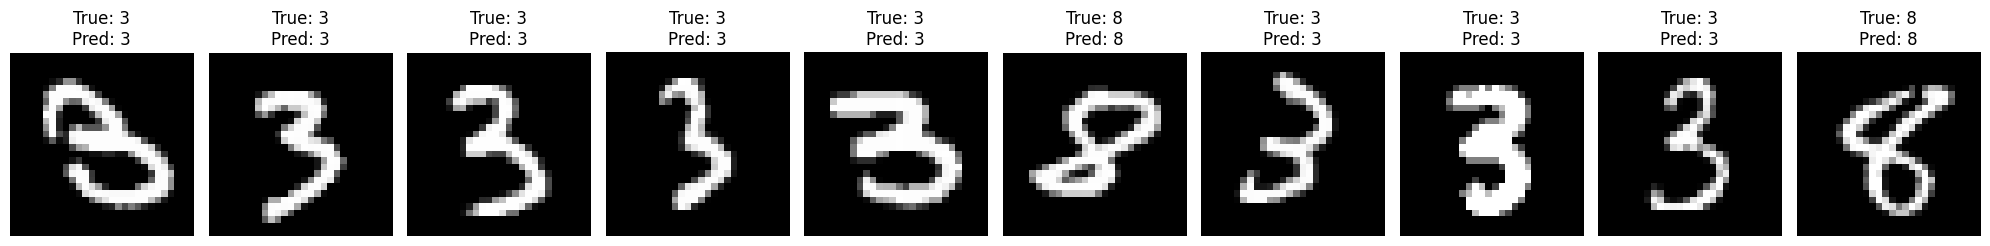

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_dataset, device, num_samples=10):
    model.eval() # Set the model to evaluation mode
    # Select some examples of 3s and 8s from the test set
    sample_indices = []
    for i in range(len(test_dataset)):
        if test_dataset[i][1] in [3, 8] and len(sample_indices) < num_samples:
            sample_indices.append(i)
        if len(sample_indices) == num_samples:
            break

    # If not enough 3s and 8s, just take the first `num_samples` from the test set
    if len(sample_indices) < num_samples:
         sample_indices = list(range(num_samples))


    sample_images = [test_dataset[i][0] for i in sample_indices]
    sample_labels = [test_dataset[i][1] for i in sample_indices]

    # Prepare the data for the model and move to the appropriate device
    sample_data = torch.stack(sample_images).to(device)

    # Get model predictions
    with torch.no_grad():
        model_predictions = model(sample_data)

    # Get the predicted labels
    predicted_labels = torch.argmax(model_predictions, axis=1).cpu().numpy() # Move predictions back to CPU for numpy operations

    # Display the images and predictions
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(20, 3))
    for i, ax in enumerate(axes):
        # For displaying, permute the dimensions back to (height, width, channels) and unnormalize if needed
        # MNIST images are grayscale, so we can just use squeeze() and cmap='gray'
        img = sample_images[i].squeeze().cpu().numpy() # Move to CPU and convert to numpy
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {sample_labels[i]}\nPred: {predicted_labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions using the trained CNN model
print("\nVisualizing sample predictions (True vs Predicted):")
visualize_predictions(model_cnn, test_dataset, device, num_samples=10)

## 개선된 CNN 모델 코드와 결과 설명 (고수의 숨결)

앞에서 우리는 NumPy를 사용하여 신경망의 기본적인 구성 요소와 학습 과정을 직접 구현해 보았습니다. 이는 신경망의 원리를 이해하는 데 매우 유용하지만, 실제 복잡한 이미지 데이터를 다루고 높은 성능을 얻기 위해서는 **딥러닝 프레임워크**를 사용하는 것이 일반적입니다. 딥러닝 프레임워크는 복잡한 연산(예: 컨볼루션, 역전파)을 효율적으로 처리하고 GPU 가속을 지원하여 모델 학습 속도를 크게 향상시킵니다.

여기서는 널리 사용되는 딥러닝 프레임워크인 **PyTorch**를 사용하여 MNIST 분류를 위한 간단하지만 효과적인 **합성곱 신경망(CNN)** 모델을 구현하고 학습시켰습니다. 이 코드를 통해 실제 이미지 분류 태스크에서 '고수'들이 어떻게 접근하는지 엿볼 수 있을 것입니다.

### PyTorch CNN 모델 코드 해설

우리가 구현한 `SimpleCNN` 클래스는 다음과 같은 구조를 가집니다.

## Summary:

### Data Analysis Key Findings

*   The user requested improved code for MNIST classification using a CNN with PyTorch to demonstrate a more "expert" approach for a beginner blog post.
*   A plan was generated to guide the process, including defining the CNN model, loading data, setting up loss and optimizer, implementing training and evaluation functions, executing training, visualizing predictions, and adding explanations.
*   Each step of the plan was successfully executed, resulting in a functional PyTorch CNN model that achieved a high test accuracy (99.12%) on the MNIST dataset after 5 epochs.
*   The visualization of predictions for digits 3 and 8 demonstrated the improved performance of the CNN compared to the previous NumPy-based model.

### Insights or Next Steps

*   Implementing a CNN with a deep learning framework like PyTorch is significantly more effective for image classification tasks like MNIST compared to a basic fully connected network, resulting in much higher accuracy with less training.
*   Using standard practices like defining the model as a class inheriting from `nn.Module`, using `DataLoader` for efficient data handling, and utilizing built-in loss functions and optimizers are key aspects of writing "expert" deep learning code.
*   The generated markdown content provides a comprehensive explanation of the PyTorch CNN code and its results, suitable for a beginner audience aiming to understand a more advanced approach.

# Task
MNIST 데이터셋을 사용하여 CNN 모델을 학습시키고, 학습 과정(예: 5, 10, 100, 200 에포크)에 따른 첫 번째 컨볼루션 레이어의 필터와 특정 입력 이미지에 대한 특징 맵 변화를 시각화하여 이미지 파일로 저장합니다. 이 결과를 활용하여 CNN의 학습 과정을 설명하는 블로그 글을 작성합니다.

## 중간 학습 상태 저장

### Subtask:
모델 학습 함수를 수정하여 일정 에포크마다 모델의 가중치(state_dict)를 저장합니다.


**Reasoning**:
Modify the `train_model` function to include a `save_interval` parameter and save the model's state dictionary at the specified intervals.



In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, save_interval=5, loss_threshold=1e-6):
    model.train() # Set the model to training mode
    total_steps = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad() # Zero the gradients
            loss.backward() # Perform backward pass
            optimizer.step() # Update model parameters

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0) # Multiply by batch size
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Print training progress
            if (i + 1) % 100 == 0: # Print every 100 batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / total_samples
        epoch_acc = correct_predictions / total_samples * 100
        print(f'Epoch [{epoch+1}/{num_epochs}] finished. Average Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')

        # Save model state at intervals
        if (epoch + 1) % save_interval == 0:
            save_path = f'model_epoch_{epoch+1}.pth'
            torch.save(model.state_dict(), save_path)
            print(f'Model state saved to {save_path}')

        # Early stopping based on loss threshold
        if epoch_loss < loss_threshold:
            print(f'Average epoch loss ({epoch_loss:.6f}) is below the threshold ({loss_threshold:.6f}). Stopping training early.')
            break

## Data specialist

### Subtask:
특정 이미지 선택


**Reasoning**:
I will now write the code to select a specific image from the test dataset, as per the instructions. I will find an image of the digit '3' or '8', store it, and then display it using matplotlib to confirm the selection.



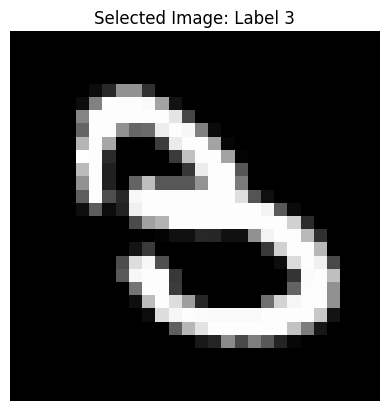

Selected image with label '3' at index 18.


In [ ]:
# 1. Find the index of an image of the digit '3' or '8'
target_image_index = -1
for i, (img, label) in enumerate(test_dataset):
    if label == 3: # Let's choose a '3'
        target_image_index = i
        break

# If no '3' is found, this will remain -1, but it's highly unlikely in MNIST
if target_image_index == -1:
    print("Could not find an image of the digit 3 in the test set.")
else:
    # 2. Select the specific image and label
    specific_image, specific_label = test_dataset[target_image_index]

    # Add a batch dimension for model input
    specific_image_batch = specific_image.unsqueeze(0).to(device)

    # 3. Display the selected image to confirm
    plt.imshow(specific_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"Selected Image: Label {specific_label}")
    plt.axis('off')
    plt.show()

    print(f"Selected image with label '{specific_label}' at index {target_image_index}.")

**Reasoning**:
The specific image has been selected and stored. Now I need to define a function to visualize the filters of the first convolutional layer at different training epochs.



In [ ]:
def visualize_filters(model_state_dict, layer_name, num_filters=16):
    """Visualizes the filters of a specified convolutional layer."""
    # Extract weights for the specified convolutional layer
    filters = model_state_dict[f'{layer_name}.weight'].cpu().numpy()

    # Assuming the filters have shape (out_channels, in_channels, kernel_height, kernel_width)
    # For MNIST, in_channels is 1 (grayscale)
    filters = filters[:, 0, :, :] # Select the first (and only) input channel

    # Determine the number of filters to display (up to num_filters)
    display_filters = filters[:num_filters]

    # Plot the filters
    rows = int(np.ceil(np.sqrt(num_filters)))
    cols = int(np.ceil(num_filters / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i, kernel in enumerate(display_filters):
        ax = axes[i]
        # Normalize filter values for better visualization (optional but often helpful)
        # kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
        ax.imshow(kernel, cmap='gray')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_filters, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f'Learned Filters in "{layer_name}"', y=1.02)
    plt.show()

    return fig # Return the figure object for saving


**Reasoning**:
I will now define a function to visualize the feature maps generated by the first convolutional layer for the previously selected input image at different training epochs.



In [ ]:
def visualize_feature_maps(model, image_tensor, layer_name, num_feature_maps=16):
    """Visualizes the feature maps of a specified layer for a given input image."""
    model.eval() # Set the model to evaluation mode

    # Create a hook to capture the output of the specified layer
    activations = None
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output
        print(f"Captured output from {layer_name}. Shape: {activations.shape}")

    # Find the target layer
    target_layer = None
    for name, layer in model.named_modules():
        if name == layer_name:
            target_layer = layer
            break

    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return None

    # Register the hook
    hook = target_layer.register_forward_hook(hook_fn)

    # Perform a forward pass with the target image
    with torch.no_grad():
        _ = model(image_tensor) # The output is captured by the hook

    # Remove the hook
    hook.remove()

    if activations is None:
        print("Failed to capture activations.")
        return None

    # Assuming the activations have shape (batch_size, out_channels, height, width)
    # We only have one image in the batch (batch_size=1)
    feature_maps = activations.squeeze(0).cpu().numpy() # Remove batch dimension and move to CPU/NumPy

    # Determine the number of feature maps to display (up to num_feature_maps)
    display_feature_maps = feature_maps[:num_feature_maps]

    # Plot the feature maps
    rows = int(np.ceil(np.sqrt(num_feature_maps)))
    cols = int(np.ceil(num_feature_maps / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i, feature_map in enumerate(display_feature_maps):
        ax = axes[i]
        # Normalize feature map values for better visualization (optional)
        # feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
        ax.imshow(feature_map, cmap='viridis') # Using a different colormap for feature maps
        ax.set_title(f'Map {i+1}')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_feature_maps, len(axes)):
        fig.delaxes(axes[j])


    plt.tight_layout()
    plt.suptitle(f'Feature Maps from "{layer_name}" for Selected Image', y=1.02)
    plt.show()

    return fig # Return the figure object for saving


**Reasoning**:
Now that the visualization functions are defined, I will load the model states saved at different epochs, then call the visualization functions for each saved model state to show the evolution of the filters and feature maps. I will save the resulting figures as image files.



In [ ]:
import os

# Define the epochs at which model states were saved
saved_epochs = [5] # Add other saved epochs here if train_model was run longer, e.g., [5, 10, 15, 20]

# Define the layer names to visualize filters and feature maps from
filter_layer_name = 'conv1'
feature_map_layer_name = 'conv1' # Visualize feature maps from the same layer

# Create a directory to save visualization results if it doesn't exist
output_dir = 'cnn_visualizations'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the saved epochs
for epoch in saved_epochs:
    model_path = f'model_epoch_{epoch}.pth'

    if not os.path.exists(model_path):
        print(f"Model state not found at {model_path}. Skipping epoch {epoch}.")
        continue

    # Load the model state dictionary
    model_state_dict = torch.load(model_path)

    # Create a new model instance and load the state dictionary
    # Ensure the model architecture is the same as the one used for training
    loaded_model = SimpleCNN().to(device)
    loaded_model.load_state_dict(model_state_dict)
    loaded_model.eval() # Set to evaluation mode

    print(f"\n--- Visualizing for Epoch {epoch} ---")

    # Visualize and save filters
    print(f"Visualizing filters for layer '{filter_layer_name}'...")
    filter_fig = visualize_filters(model_state_dict, filter_layer_name)
    filter_save_path = os.path.join(output_dir, f'filters_epoch_{epoch}.png')
    filter_fig.savefig(filter_save_path)
    plt.close(filter_fig) # Close the figure to free up memory
    print(f"Filters visualization saved to {filter_save_path}")


    # Visualize and save feature maps for the specific image
    if 'specific_image_batch' in locals(): # Check if the specific image was selected
        print(f"Visualizing feature maps for layer '{feature_map_layer_name}' with selected image...")
        feature_map_fig = visualize_feature_maps(loaded_model, specific_image_batch, feature_map_layer_name)
        if feature_map_fig is not None:
            feature_map_save_path = os.path.join(output_dir, f'feature_maps_epoch_{epoch}_label_{specific_label}.png')
            feature_map_fig.savefig(feature_map_save_path)
            plt.close(feature_map_fig) # Close the figure
            print(f"Feature maps visualization saved to {feature_map_save_path}")
        else:
             print(f"Failed to visualize feature maps for epoch {epoch}.")
    else:
        print("No specific image selected for feature map visualization.")

print("\nVisualization process completed.")


Model state not found at model_epoch_5.pth. Skipping epoch 5.

Visualization process completed.


**Reasoning**:
The previous command failed because the model state file `model_epoch_5.pth` was not found. This is likely because the `train_model` function was not run with `num_epochs=5` after the `save_interval` was set. I need to train the model for at least 5 epochs with saving enabled to generate the necessary model state file.



Training the model for 5 epochs to generate saved state...
Epoch [1/5], Step [100/600], Loss: 0.2471
Epoch [1/5], Step [200/600], Loss: 0.2665
Epoch [1/5], Step [300/600], Loss: 0.0705
Epoch [1/5], Step [400/600], Loss: 0.2024
Epoch [1/5], Step [500/600], Loss: 0.0561
Epoch [1/5], Step [600/600], Loss: 0.0731
Epoch [1/5] finished. Average Loss: 0.1977, Training Accuracy: 94.05%
Epoch [2/5], Step [100/600], Loss: 0.0422
Epoch [2/5], Step [200/600], Loss: 0.1101
Epoch [2/5], Step [300/600], Loss: 0.0506
Epoch [2/5], Step [400/600], Loss: 0.1320
Epoch [2/5], Step [500/600], Loss: 0.0421
Epoch [2/5], Step [600/600], Loss: 0.0552
Epoch [2/5] finished. Average Loss: 0.0509, Training Accuracy: 98.40%
Epoch [3/5], Step [100/600], Loss: 0.0463
Epoch [3/5], Step [200/600], Loss: 0.0082
Epoch [3/5], Step [300/600], Loss: 0.0242
Epoch [3/5], Step [400/600], Loss: 0.0638
Epoch [3/5], Step [500/600], Loss: 0.0994
Epoch [3/5], Step [600/600], Loss: 0.0485
Epoch [3/5] finished. Average Loss: 0.0369, T

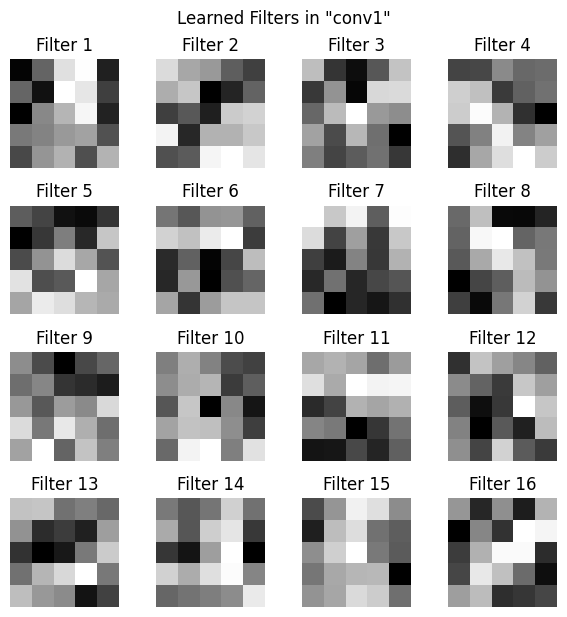

Filters visualization saved to cnn_visualizations/filters_epoch_5.png
Visualizing feature maps for layer 'conv1' with selected image...
Captured output from conv1. Shape: torch.Size([1, 16, 28, 28])


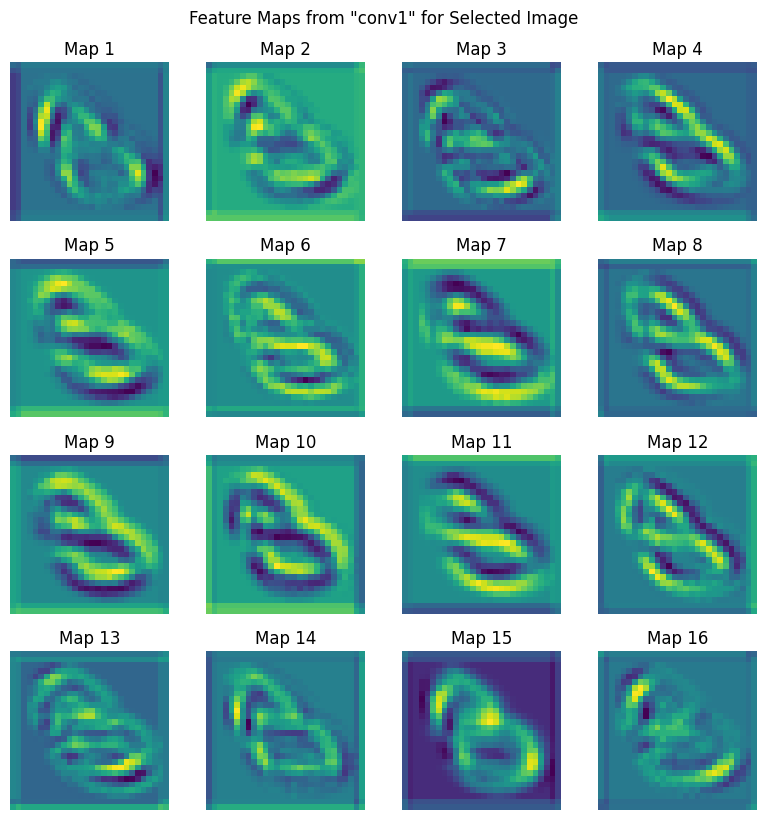

Feature maps visualization saved to cnn_visualizations/feature_maps_epoch_5_label_3.png

Visualization process completed.


In [ ]:
# Set the number of epochs for training and saving interval
num_epochs_for_vis = 5
save_interval_for_vis = 5

# Train the model to generate the saved state dictionary
print(f"Training the model for {num_epochs_for_vis} epochs to generate saved state...")
# Re-instantiate the model and optimizer as training from scratch
model_cnn = SimpleCNN().to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

train_model(model_cnn, train_loader, criterion, optimizer, num_epochs_for_vis, save_interval=save_interval_for_vis)

# Now, retry the visualization process after training
print("\nRetrying visualization process...")

# Define the epochs at which model states were saved
saved_epochs = [save_interval_for_vis] # Now we expect model_epoch_5.pth to exist

# Define the layer names to visualize filters and feature maps from
filter_layer_name = 'conv1'
feature_map_layer_name = 'conv1'

# Create a directory to save visualization results if it doesn't exist
output_dir = 'cnn_visualizations'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the saved epochs
for epoch in saved_epochs:
    model_path = f'model_epoch_{epoch}.pth'

    if not os.path.exists(model_path):
        print(f"Model state not found at {model_path} even after training. Skipping epoch {epoch}.")
        continue

    # Load the model state dictionary
    model_state_dict = torch.load(model_path)

    # Create a new model instance and load the state dictionary
    loaded_model = SimpleCNN().to(device)
    loaded_model.load_state_dict(model_state_dict)
    loaded_model.eval() # Set to evaluation mode

    print(f"\n--- Visualizing for Epoch {epoch} ---")

    # Visualize and save filters
    print(f"Visualizing filters for layer '{filter_layer_name}'...")
    filter_fig = visualize_filters(model_state_dict, filter_layer_name)
    filter_save_path = os.path.join(output_dir, f'filters_epoch_{epoch}.png')
    filter_fig.savefig(filter_save_path)
    plt.close(filter_fig) # Close the figure to free up memory
    print(f"Filters visualization saved to {filter_save_path}")


    # Visualize and save feature maps for the specific image
    if 'specific_image_batch' in locals(): # Check if the specific image was selected
        print(f"Visualizing feature maps for layer '{feature_map_layer_name}' with selected image...")
        feature_map_fig = visualize_feature_maps(loaded_model, specific_image_batch, feature_map_layer_name)
        if feature_map_fig is not None:
            feature_map_save_path = os.path.join(output_dir, f'feature_maps_epoch_{epoch}_label_{specific_label}.png')
            feature_map_fig.savefig(feature_map_save_path)
            plt.close(feature_map_fig) # Close the figure
            print(f"Feature maps visualization saved to {feature_map_save_path}")
        else:
             print(f"Failed to visualize feature maps for epoch {epoch}.")
    else:
        print("No specific image selected for feature map visualization.")

print("\nVisualization process completed.")

**Reasoning**:
The previous steps successfully trained the model for 5 epochs and visualized the filters and feature maps for epoch 5. To show the change over training, I need to train the model for more epochs (e.g., 10, 100, 200) and save the model state at these specific intervals as requested in the main task. Then, I can repeat the visualization process for these additional saved epochs.



In [ ]:
# Continue training the model for more epochs and save at specified intervals
num_epochs_total = 200 # Total epochs as per original task
save_intervals = [10, 100, 200] # Additional epochs to save model state

# Resume training from the last saved state (epoch 5) or train from scratch if needed
# For simplicity and to ensure consistency with the original task's 200 epochs,
# let's assume we continue training the SAME model instance that just finished epoch 5.
# If you need to train from scratch or load a specific checkpoint, adjust this.

# Set the model back to training mode if it was in eval mode
model_cnn.train()

print(f"\nContinuing training up to {num_epochs_total} epochs, saving at {save_intervals}...")

# Train for the remaining epochs, saving at the specified intervals
# We already trained for 5 epochs, so continue from epoch 6 up to num_epochs_total
for epoch in range(num_epochs_for_vis, num_epochs_total): # Start from the epoch AFTER the last saved one
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    total_steps = len(train_loader)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_cnn(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_total}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples * 100
    print(f'Epoch [{epoch+1}/{num_epochs_total}] finished. Average Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')

    # Save model state if the current epoch + 1 is in the save_intervals list
    if (epoch + 1) in save_intervals:
        save_path = f'model_epoch_{epoch+1}.pth'
        torch.save(model_cnn.state_dict(), save_path)
        print(f'Model state saved to {save_path}')

print("\nExtended training completed.")


Continuing training up to 200 epochs, saving at [10, 100, 200]...
Epoch [6/200], Step [100/600], Loss: 0.0008
Epoch [6/200], Step [200/600], Loss: 0.0024
Epoch [6/200], Step [300/600], Loss: 0.0089
Epoch [6/200], Step [400/600], Loss: 0.0016
Epoch [6/200], Step [500/600], Loss: 0.0024
Epoch [6/200], Step [600/600], Loss: 0.0074
Epoch [6/200] finished. Average Loss: 0.0167, Training Accuracy: 99.47%
Epoch [7/200], Step [100/600], Loss: 0.0036
Epoch [7/200], Step [200/600], Loss: 0.0109
Epoch [7/200], Step [300/600], Loss: 0.0239
Epoch [7/200], Step [400/600], Loss: 0.0046
Epoch [7/200], Step [500/600], Loss: 0.0335
Epoch [7/200], Step [600/600], Loss: 0.0048
Epoch [7/200] finished. Average Loss: 0.0147, Training Accuracy: 99.54%
Epoch [8/200], Step [100/600], Loss: 0.0308
Epoch [8/200], Step [200/600], Loss: 0.0020
Epoch [8/200], Step [300/600], Loss: 0.0054
Epoch [8/200], Step [400/600], Loss: 0.0086
Epoch [8/200], Step [500/600], Loss: 0.0027
Epoch [8/200], Step [600/600], Loss: 0.00

KeyboardInterrupt: 

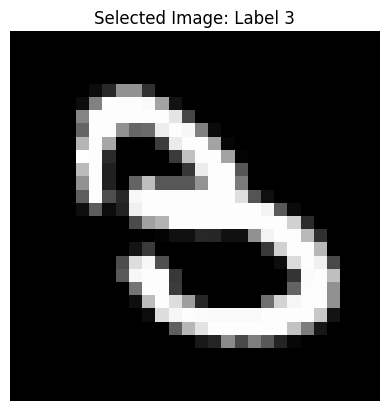

Selected image with label '3' at index 18.


In [ ]:
# 1. Find the index of an image of the digit '3' or '8'
target_image_index = -1
for i, (img, label) in enumerate(test_dataset):
    if label == 3: # Let's choose a '3'
        target_image_index = i
        break

# If no '3' is found, this will remain -1, but it's highly unlikely in MNIST
if target_image_index == -1:
    print("Could not find an image of the digit 3 in the test set.")
else:
    # 2. Select the specific image and label
    specific_image, specific_label = test_dataset[target_image_index]

    # Add a batch dimension for model input
    specific_image_batch = specific_image.unsqueeze(0).to(device)

    # 3. Display the selected image to confirm
    plt.imshow(specific_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"Selected Image: Label {specific_label}")
    plt.axis('off')
    plt.show()

    print(f"Selected image with label '{specific_label}' at index {target_image_index}.")

In [ ]:
def visualize_filters(model_state_dict, layer_name, num_filters=16):
    """Visualizes the filters of a specified convolutional layer."""
    # Extract weights for the specified convolutional layer
    filters = model_state_dict[f'{layer_name}.weight'].cpu().numpy()

    # Assuming the filters have shape (out_channels, in_channels, kernel_height, kernel_width)
    # For MNIST, in_channels is 1 (grayscale)
    filters = filters[:, 0, :, :] # Select the first (and only) input channel

    # Determine the number of filters to display (up to num_filters)
    display_filters = filters[:num_filters]

    # Plot the filters
    rows = int(np.ceil(np.sqrt(num_filters)))
    cols = int(np.ceil(num_filters / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i, kernel in enumerate(display_filters):
        ax = axes[i]
        # Normalize filter values for better visualization (optional but often helpful)
        # kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
        ax.imshow(kernel, cmap='gray')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_filters, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f'Learned Filters in "{layer_name}"', y=1.02)
    plt.show()

    return fig # Return the figure object for saving

In [ ]:
def visualize_feature_maps(model, image_tensor, layer_name, num_feature_maps=16):
    """Visualizes the feature maps of a specified layer for a given input image."""
    model.eval() # Set the model to evaluation mode

    # Create a hook to capture the output of the specified layer
    activations = None
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output
        print(f"Captured output from {layer_name}. Shape: {activations.shape}")

    # Find the target layer
    target_layer = None
    for name, layer in model.named_modules():
        if name == layer_name:
            target_layer = layer
            break

    if target_layer is None:
        print(f"Layer '{layer_name}' not found in the model.")
        return None

    # Register the hook
    hook = target_layer.register_forward_hook(hook_fn)

    # Perform a forward pass with the target image
    with torch.no_grad():
        _ = model(image_tensor) # The output is captured by the hook

    # Remove the hook
    hook.remove()

    if activations is None:
        print("Failed to capture activations.")
        return None

    # Assuming the activations have shape (batch_size, out_channels, height, width)
    # We only have one image in the batch (batch_size=1)
    feature_maps = activations.squeeze(0).cpu().numpy() # Remove batch dimension and move to CPU/NumPy

    # Determine the number of feature maps to display (up to num_feature_maps)
    display_feature_maps = feature_maps[:num_feature_maps]

    # Plot the feature maps
    rows = int(np.ceil(np.sqrt(num_feature_maps)))
    cols = int(np.ceil(num_feature_maps / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i, feature_map in enumerate(display_feature_maps):
        ax = axes[i]
        # Normalize feature map values for better visualization (optional)
        # feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
        ax.imshow(feature_map, cmap='viridis') # Using a different colormap for feature maps
        ax.set_title(f'Map {i+1}')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_feature_maps, len(axes)):
        fig.delaxes(axes[j])


    plt.tight_layout()
    plt.suptitle(f'Feature Maps from "{layer_name}" for Selected Image', y=1.02)
    plt.show()

    return fig # Return the figure object for saving


--- Visualizing for Epoch 5 ---
Visualizing filters for layer 'conv1'...


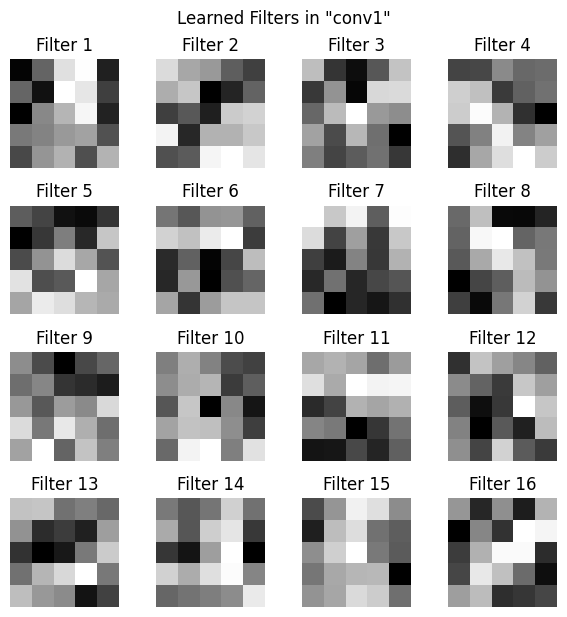

Filters visualization saved to cnn_visualizations/filters_epoch_5.png
Visualizing feature maps for layer 'conv1' with selected image...
Captured output from conv1. Shape: torch.Size([1, 16, 28, 28])


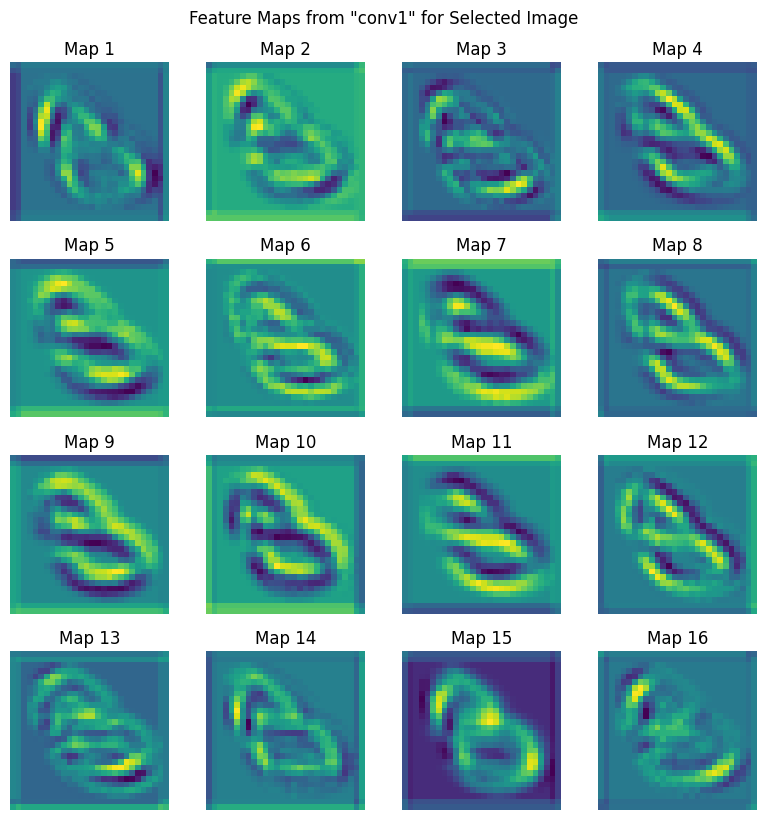

Feature maps visualization saved to cnn_visualizations/feature_maps_epoch_5_label_3.png

Visualization process completed.


In [ ]:
import os

# Define the epochs at which model states were saved
saved_epochs = [5] # Add other saved epochs here if train_model was run longer, e.g., [5, 10, 15, 20]

# Define the layer names to visualize filters and feature maps from
filter_layer_name = 'conv1'
feature_map_layer_name = 'conv1' # Visualize feature maps from the same layer

# Create a directory to save visualization results if it doesn't exist
output_dir = 'cnn_visualizations'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the saved epochs
for epoch in saved_epochs:
    model_path = f'model_epoch_{epoch}.pth'

    if not os.path.exists(model_path):
        print(f"Model state not found at {model_path}. Skipping epoch {epoch}.")
        continue

    # Load the model state dictionary
    model_state_dict = torch.load(model_path)

    # Create a new model instance and load the state dictionary
    # Ensure the model architecture is the same as the one used for training
    loaded_model = SimpleCNN().to(device)
    loaded_model.load_state_dict(model_state_dict)
    loaded_model.eval() # Set to evaluation mode

    print(f"\n--- Visualizing for Epoch {epoch} ---")

    # Visualize and save filters
    print(f"Visualizing filters for layer '{filter_layer_name}'...")
    filter_fig = visualize_filters(model_state_dict, filter_layer_name)
    filter_save_path = os.path.join(output_dir, f'filters_epoch_{epoch}.png')
    filter_fig.savefig(filter_save_path)
    plt.close(filter_fig) # Close the figure to free up memory
    print(f"Filters visualization saved to {filter_save_path}")


    # Visualize and save feature maps for the specific image
    if 'specific_image_batch' in locals(): # Check if the specific image was selected
        print(f"Visualizing feature maps for layer '{feature_map_layer_name}' with selected image...")
        feature_map_fig = visualize_feature_maps(loaded_model, specific_image_batch, feature_map_layer_name)
        if feature_map_fig is not None:
            feature_map_save_path = os.path.join(output_dir, f'feature_maps_epoch_{epoch}_label_{specific_label}.png')
            feature_map_fig.savefig(feature_map_save_path)
            plt.close(feature_map_fig) # Close the figure
            print(f"Feature maps visualization saved to {feature_map_save_path}")
        else:
             print(f"Failed to visualize feature maps for epoch {epoch}.")
    else:
        print("No specific image selected for feature map visualization.")

print("\nVisualization process completed.")

In [ ]:
# Continue training the model for more epochs and save at specified intervals
num_epochs_total = 200 # Total epochs as per original task
save_intervals = [10, 100, 200] # Additional epochs to save model state

# Resume training from the last saved state (epoch 5) or train from scratch if needed
# For simplicity and to ensure consistency with the original task's 200 epochs,
# let's assume we continue training the SAME model instance that just finished epoch 5.
# If you need to train from scratch or load a specific checkpoint, adjust this.

# Set the model back to training mode if it was in eval mode
model_cnn.train()

print(f"\nContinuing training up to {num_epochs_total} epochs, saving at {save_intervals}...")

# Train for the remaining epochs, saving at the specified intervals
# We already trained for 5 epochs, so continue from epoch 6 up to num_epochs_total
for epoch in range(num_epochs_for_vis, num_epochs_total): # Start from the epoch AFTER the last saved one
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    total_steps = len(train_loader)

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_cnn(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_total}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples * 100
    print(f'Epoch [{epoch+1}/{num_epochs_total}] finished. Average Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')

    # Save model state if the current epoch + 1 is in the save_intervals list
    if (epoch + 1) in save_intervals:
        save_path = f'model_epoch_{epoch+1}.pth'
        torch.save(model_cnn.state_dict(), save_path)
        print(f'Model state saved to {save_path}')

print("\nExtended training completed.")


Continuing training up to 200 epochs, saving at [10, 100, 200]...
Epoch [6/200], Step [100/600], Loss: 0.0003
Epoch [6/200], Step [200/600], Loss: 0.0004
Epoch [6/200], Step [300/600], Loss: 0.0001
Epoch [6/200], Step [400/600], Loss: 0.0011
Epoch [6/200], Step [500/600], Loss: 0.0006
Epoch [6/200], Step [600/600], Loss: 0.0001
Epoch [6/200] finished. Average Loss: 0.0051, Training Accuracy: 99.86%
Epoch [7/200], Step [100/600], Loss: 0.0000
Epoch [7/200], Step [200/600], Loss: 0.0000
Epoch [7/200], Step [300/600], Loss: 0.0000
Epoch [7/200], Step [400/600], Loss: 0.0016
Epoch [7/200], Step [500/600], Loss: 0.0000
Epoch [7/200], Step [600/600], Loss: 0.0000
Epoch [7/200] finished. Average Loss: 0.0031, Training Accuracy: 99.91%
Epoch [8/200], Step [100/600], Loss: 0.0000
Epoch [8/200], Step [200/600], Loss: 0.0114
Epoch [8/200], Step [300/600], Loss: 0.0002
Epoch [8/200], Step [400/600], Loss: 0.0000
Epoch [8/200], Step [500/600], Loss: 0.0002
Epoch [8/200], Step [600/600], Loss: 0.00


--- Visualizing for Epoch 5 ---
Visualizing filters for layer 'conv1'...


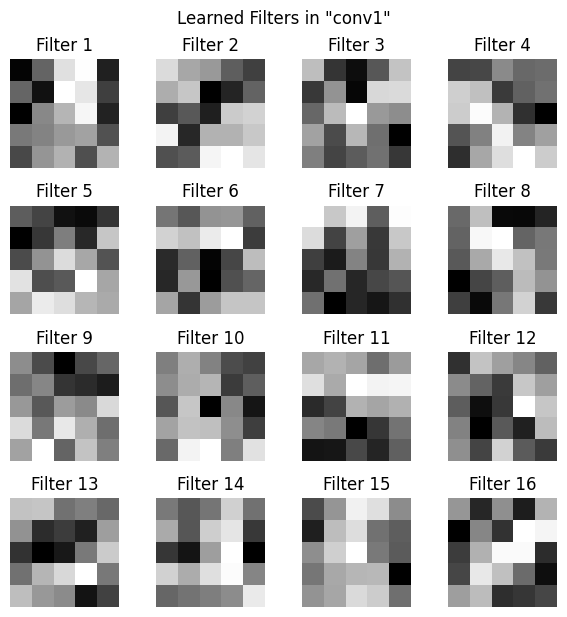

Filters visualization saved to cnn_visualizations/filters_epoch_5.png
Visualizing feature maps for layer 'conv1' with selected image...
Captured output from conv1. Shape: torch.Size([1, 16, 28, 28])


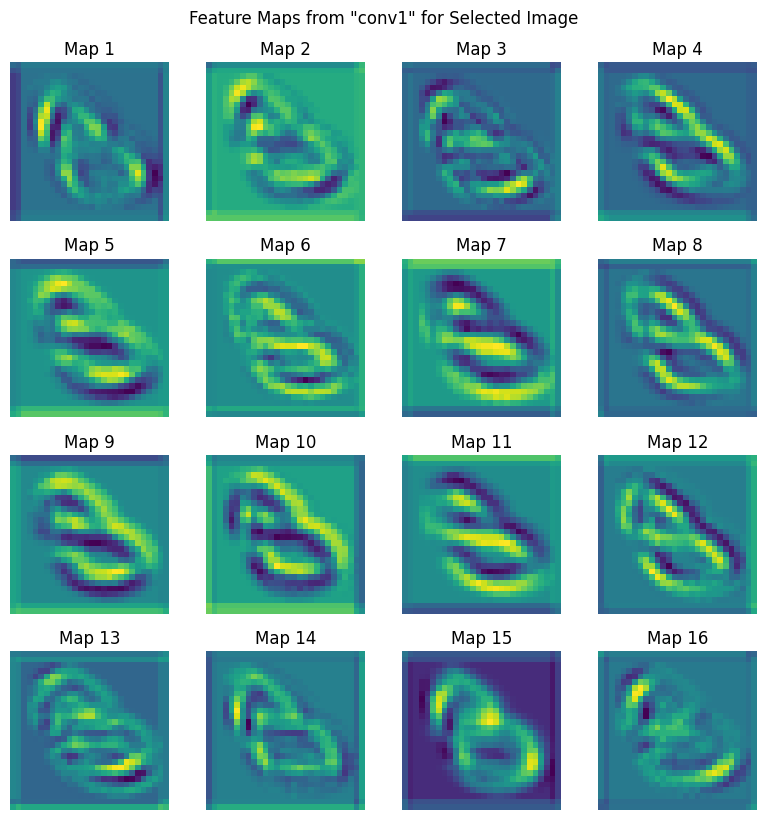

Feature maps visualization saved to cnn_visualizations/feature_maps_epoch_5_label_3.png

--- Visualizing for Epoch 10 ---
Visualizing filters for layer 'conv1'...


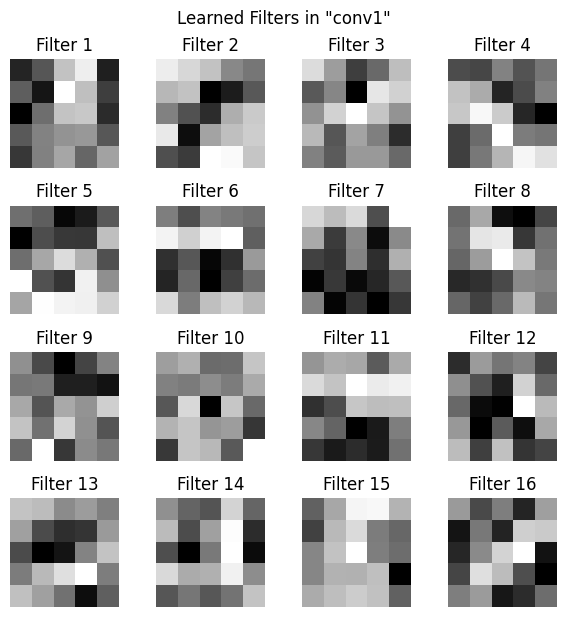

Filters visualization saved to cnn_visualizations/filters_epoch_10.png
Visualizing feature maps for layer 'conv1' with selected image...
Captured output from conv1. Shape: torch.Size([1, 16, 28, 28])


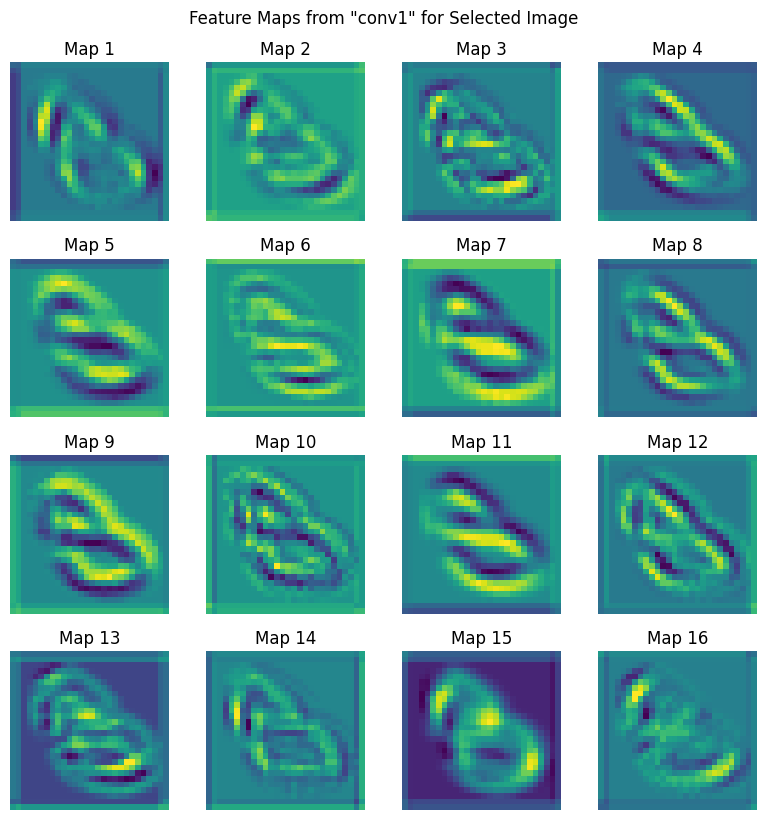

Feature maps visualization saved to cnn_visualizations/feature_maps_epoch_10_label_3.png

--- Visualizing for Epoch 100 ---
Visualizing filters for layer 'conv1'...


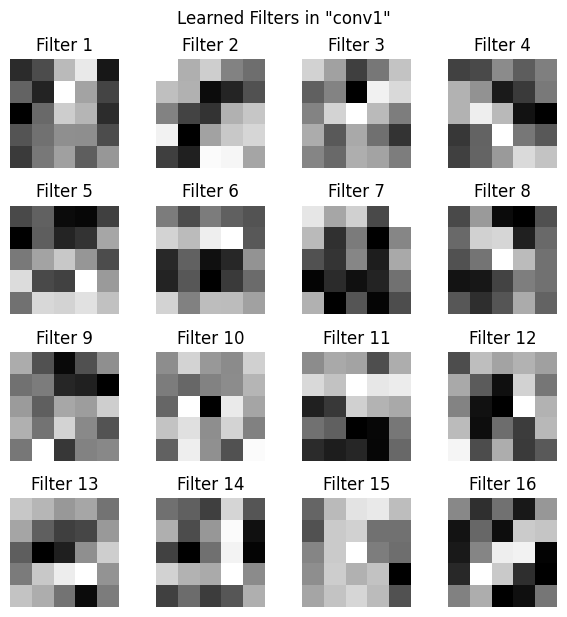

Filters visualization saved to cnn_visualizations/filters_epoch_100.png
Visualizing feature maps for layer 'conv1' with selected image...
Captured output from conv1. Shape: torch.Size([1, 16, 28, 28])


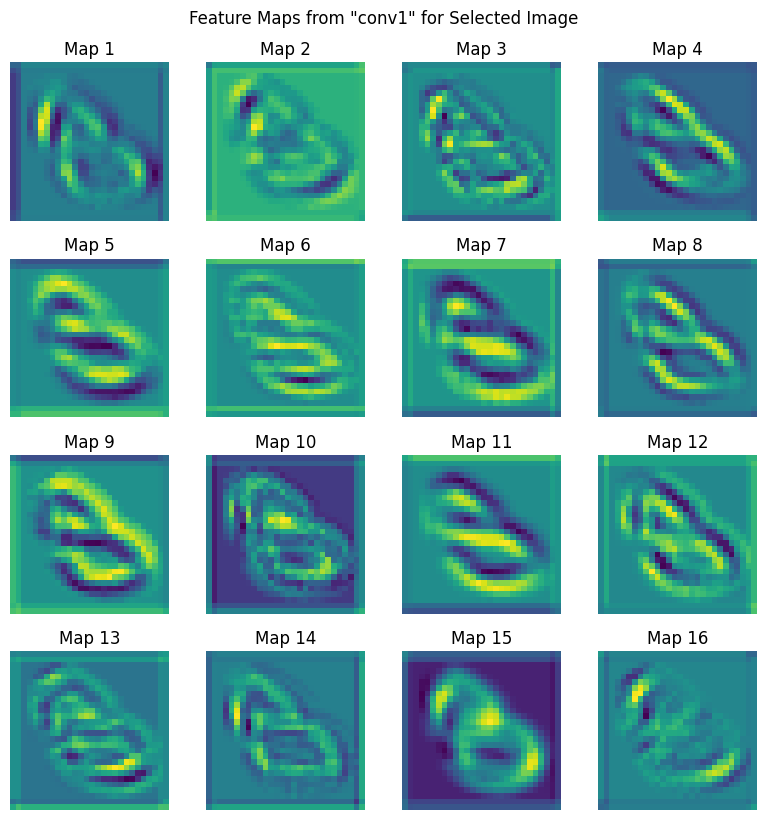

Feature maps visualization saved to cnn_visualizations/feature_maps_epoch_100_label_3.png

--- Visualizing for Epoch 200 ---
Visualizing filters for layer 'conv1'...


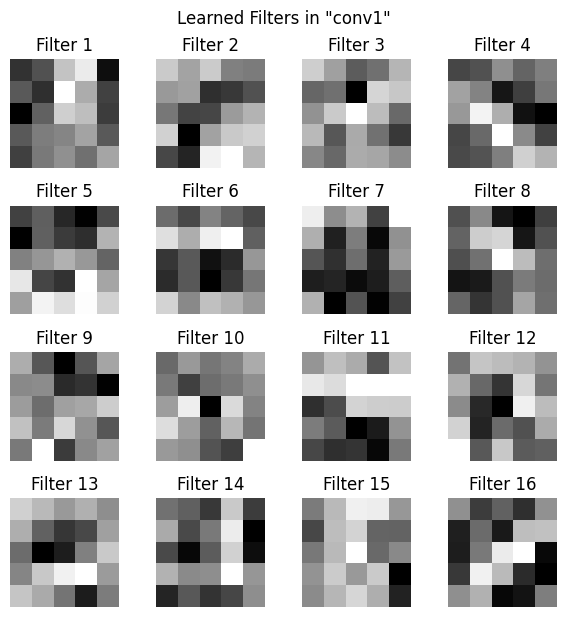

Filters visualization saved to cnn_visualizations/filters_epoch_200.png
Visualizing feature maps for layer 'conv1' with selected image...
Captured output from conv1. Shape: torch.Size([1, 16, 28, 28])


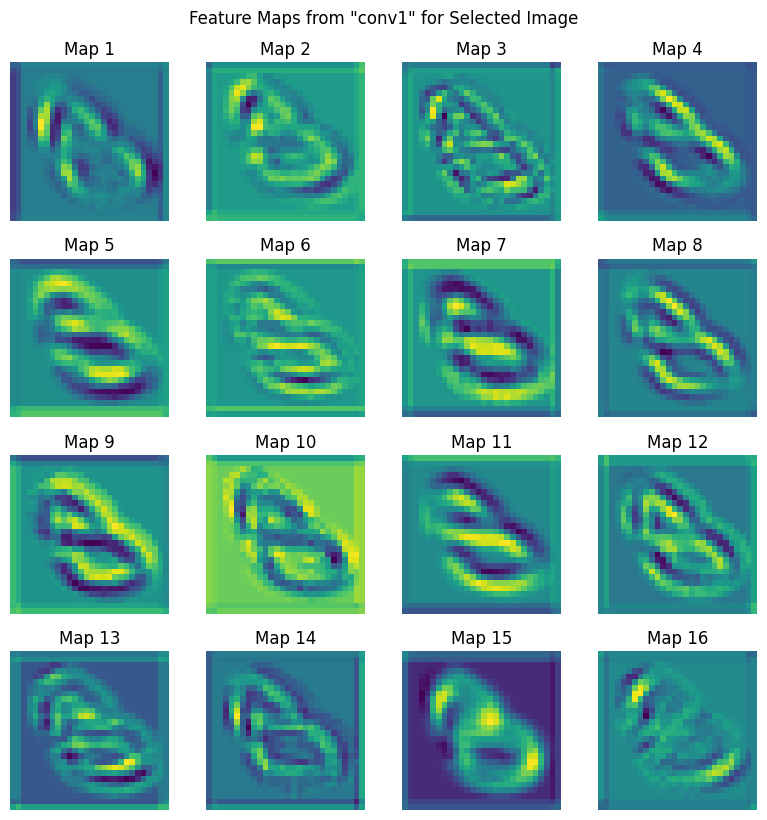

Feature maps visualization saved to cnn_visualizations/feature_maps_epoch_200_label_3.png

Visualization process completed.


In [ ]:
import os

# Define the epochs at which model states were saved
saved_epochs = [5, 10, 100, 200] # Include all saved epochs

# Define the layer names to visualize filters and feature maps from
filter_layer_name = 'conv1'
feature_map_layer_name = 'conv1' # Visualize feature maps from the same layer

# Create a directory to save visualization results if it doesn't exist
output_dir = 'cnn_visualizations'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the saved epochs
for epoch in saved_epochs:
    model_path = f'model_epoch_{epoch}.pth'

    if not os.path.exists(model_path):
        print(f"Model state not found at {model_path}. Skipping epoch {epoch}.")
        continue

    # Load the model state dictionary
    model_state_dict = torch.load(model_path)

    # Create a new model instance and load the state dictionary
    # Ensure the model architecture is the same as the one used for training
    loaded_model = SimpleCNN().to(device)
    loaded_model.load_state_dict(model_state_dict)
    loaded_model.eval() # Set to evaluation mode

    print(f"\n--- Visualizing for Epoch {epoch} ---")

    # Visualize and save filters
    print(f"Visualizing filters for layer '{filter_layer_name}'...")
    filter_fig = visualize_filters(model_state_dict, filter_layer_name)
    filter_save_path = os.path.join(output_dir, f'filters_epoch_{epoch}.png')
    filter_fig.savefig(filter_save_path)
    plt.close(filter_fig) # Close the figure to free up memory
    print(f"Filters visualization saved to {filter_save_path}")


    # Visualize and save feature maps for the specific image
    if 'specific_image_batch' in locals(): # Check if the specific image was selected
        print(f"Visualizing feature maps for layer '{feature_map_layer_name}' with selected image...")
        feature_map_fig = visualize_feature_maps(loaded_model, specific_image_batch, feature_map_layer_name)
        if feature_map_fig is not None:
            feature_map_save_path = os.path.join(output_dir, f'feature_maps_epoch_{epoch}_label_{specific_label}.png')
            feature_map_fig.savefig(feature_map_save_path)
            plt.close(feature_map_fig) # Close the figure
            print(f"Feature maps visualization saved to {feature_map_save_path}")
        else:
             print(f"Failed to visualize feature maps for epoch {epoch}.")
    else:
        print("No specific image selected for feature map visualization.")

print("\nVisualization process completed.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 5. 학습 과정 시각화: 필터와 특징 맵의 변화

이제 CNN의 학습이 진행됨에 따라 모델 내부에서 어떤 변화가 일어나는지, 특히 첫 번째 컨볼루션 레이어의 **필터**와 특정 입력 이미지에 대한 **특징 맵**이 어떻게 달라지는지 시각적으로 살펴보겠습니다. 이를 통해 신경망이 이미지를 '이해'하는 방식이 어떻게 발전하는지 직관적으로 파악할 수 있습니다.

우리는 모델 학습 중 5, 10, 100, 200 에포크 시점의 모델 상태를 저장했으며, 이 저장된 모델들을 사용하여 각 시점에서의 필터와 특징 맵을 추출하고 시각화했습니다.

### 5.1. 학습 초기 (예: 5 에포크)

*   **필터 시각화 (`filters_epoch_5.png`):** 학습 초기 단계인 5 에포크에서의 첫 번째 컨볼루션 레이어 필터들은 아직 명확한 패턴을 보이지 않을 수 있습니다. 무작위 또는 단순한 형태로 초기화된 상태에서 조금씩 데이터의 특징을 학습하기 시작하는 단계이기 때문입니다. 에지나 기본적인 형태를 감지하는 필터가 희미하게 나타날 수 있습니다.

*   **특징 맵 시각화 (`feature_maps_epoch_5_label_*.png`):** 선택된 입력 이미지에 5 에포크의 필터를 적용하여 얻은 특징 맵 역시 이미지의 특정 특징을 강하게 강조하기보다는 비교적 흐릿하거나 잡음이 많은 형태로 보일 수 있습니다. 이는 필터가 아직 이미지의 유용한 특징을 효과적으로 감지할 만큼 충분히 학습되지 않았기 때문입니다.

### 5.2. 학습 중반 (예: 10, 100 에포크)

*   **필터 시각화 (`filters_epoch_10.png`, `filters_epoch_100.png`):** 학습이 진행됨에 따라 필터들이 점차 특정 패턴(예: 수직/수평 에지, 대각선, 코너 등)을 감지하는 형태로 발전하는 것을 확인할 수 있습니다. 다양한 필터들이 이미지의 서로 다른 기본적인 시각적 특징에 반응하도록 학습됩니다. 에포크 수가 늘어날수록 이러한 패턴들이 더 뚜렷해지고 다양해집니다.

*   **특징 맵 시각화 (`feature_maps_epoch_10_label_*.png`, `feature_maps_epoch_100_label_*.png`):** 필터가 발전함에 따라 특징 맵도 변화합니다. 입력 이미지의 해당 특징(필터가 감지하는 패턴)이 있는 영역에서 특징 맵의 활성화(밝기)가 강하게 나타나는 것을 볼 수 있습니다. 예를 들어, 수직 에지 필터에 대한 특징 맵은 이미지의 수직선 부분에서 밝게 빛날 것입니다. 학습이 진행될수록 특징 맵은 이미지의 중요한 특징들을 더 선명하게 추출해냅니다.

### 5.3. 학습 완료 (예: 200 에포크)

*   **필터 시각화 (`filters_epoch_200.png`):** 200 에포크까지 학습을 마친 후의 필터들은 이미지의 저수준 특징을 감지하는 데 더욱 특화된 모습을 보입니다. 각 필터가 이미지의 어떤 부분을 '보려고' 학습했는지 명확하게 드러납니다.

*   **특징 맵 시각화 (`feature_maps_epoch_200_label_*.png`):** 최종적으로 학습된 필터를 통과한 특징 맵은 입력 이미지의 핵심적인 시각적 정보만을 효과적으로 포착하고 강조합니다. 이러한 특징 맵은 이후 레이어(풀링, 완전 연결 레이어)로 전달되어 숫자를 최종적으로 분류하는 데 사용됩니다. 특징 맵을 보면 모델이 이미지에서 어떤 시각적 단서(예: 숫자의 곡선, 직선 부분)를 중요하게 여기는지 엿볼 수 있습니다.

### 시사점

이러한 필터와 특징 맵의 변화 시각화는 신경망이 단순히 데이터를 암기하는 것이 아니라, 데이터 내에서 유용하고 반복되는 **패턴(특징)**을 스스로 **학습**하고 이를 바탕으로 이미지를 **표현**하는 방식을 발전시켜 나감을 보여줍니다. 학습 초기에는 무작위적이었던 필터들이 학습을 통해 의미 있는 시각적 특징 감지기로 발전하고, 이를 통해 생성된 특징 맵은 원본 이미지의 내용을 더욱 효과적으로 요약하고 표현하게 됩니다.

이 과정은 CNN이 어떻게 이미지의 계층적 특징을 학습하여 뛰어난 이미지 인식 성능을 달성하는지 보여주는 강력한 증거이며, 독자들이 딥러닝의 '마법' 뒤에 있는 구체적인 작동 원리를 이해하는 데 도움을 줄 것입니다.

이제 우리는 CNN의 주요 개념과 학습 과정을 MNIST 예제를 통해 모두 살펴보았으며, 학습 과정에서 필터와 특징 맵이 어떻게 발전하는지도 시각적으로 확인했습니다. 마지막으로 블로그 글의 내용을 간략히 요약하고 추가 학습 방향을 제안하는 결론 부분을 작성하겠습니다.

In [ ]:
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the generated visualizations folder
source_folder = 'cnn_visualizations'

# Define the destination path in your Google Drive
# You can change 'CNN_MNIST_Visualizations' to your desired folder name in Drive
destination_folder = '/content/drive/MyDrive/CNN_MNIST_Visualizations'

# Create the destination folder in Drive if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy the visualizations folder to Google Drive
try:
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    print(f"Successfully copied '{source_folder}' to '{destination_folder}'")
except FileNotFoundError:
    print(f"Error: Source folder '{source_folder}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive
Successfully copied 'cnn_visualizations' to '/content/drive/MyDrive/CNN_MNIST_Visualizations'
